In [1]:
%matplotlib notebook

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

In [2]:
import radvel
import astropy.units as u
import astropy.constants as co

/Users/neisner/opt/anaconda3/envs/exoplanet/lib/python3.9/site-packages/radvel/gp.py:32: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  warnings.warn("celerite not installed. GP kernals using celerite will not work. \


In [3]:
period = 1.104686 #1.10462 #1.1047115
t0 = 2458766.2700 - 2457000 

def get_etv_data(files):

    period = 1.1047115
    t0 = 2398.164 
    
    x_etv =  []
    y_etv =  []
    yerr_etv  = []
    yerr_etv2 = []
    
    for file in files:
        in_df = pd.read_csv(file)
        
        in_df['midpoint'] = in_df['epoch'] #+ (in_df['t0']*period)
        in_df['shift_mins'] = in_df['t0']*period*24*60
        in_df['std_mins'] = in_df['stdv']*period*24*60
        
        x_etv.append(np.array(list(in_df['epoch'])))
        y_etv.append(np.array(list(in_df['shift_mins'])))
        yerr_etv.append(np.array(list(in_df['std_mins'])))
        
    x_etv = np.hstack(x_etv)
    y_etv = np.hstack(y_etv)
    yerr_etv = np.hstack(yerr_etv)
    
    p4 = 4.092
    t04 = 1765.17
    
    for i in range(0,55):
        
        time = t04 + (i*p4)
        
        mask = (x_etv > time - 0.15) & (x_etv < time + 0.15)
        
        x_etv = x_etv[~mask]
        y_etv = y_etv[~mask]
        yerr_etv = yerr_etv[~mask]
    
    #print (len(x_etv), len(y_etv), len(yerr_etv), len(yerr_etv2))
    
    return x_etv, y_etv, yerr_etv
    
    
def get_rv_data(file):

    data_rv = pd.read_csv(file, delimiter = ' ', names = ['time', 'rv', 'snr', 'err'])

    data_rv['time_tjd'] = data_rv['time'] - 2457000.0

    x_rv = np.array(data_rv['time_tjd'].tolist())
    y_rv = np.array(data_rv['rv'].tolist())
    yerr_rv = np.array(data_rv['err'].tolist())

    return x_rv, y_rv, yerr_rv


In [4]:
from glob import glob 


files = sorted(glob('/Users/neisner/Documents/projects/fluffy/reanalysed/onedaysignal/mcmc_etvs_*csv'))

#print (files)

x_etv, y_etv, yerr_etv = get_etv_data(files)


t, rv, rv_err = get_rv_data('/Users/neisner/Documents/projects/fluffy/HERMES_extracted/mean_helium_rvs_snr.txt')
x_etv, y_etv, yerr_etv = zip(*sorted(zip(x_etv,y_etv,yerr_etv)))

rv_dat = pd.read_csv('/Users/neisner/Documents/projects/fluffy/HERMES_extracted/mean_helium_rvs_snr.txt', delimiter = ' ', names = ['t', 'rv', 'snr', 'err'])
#fig, ax = plt.subplots(figsize=(8, 3))

#plt.errorbar(rv_dat.t, rv_dat.rv, yerr = rv_error, lw = 0, elinewidth = 2, marker = '.')

rv_error = ((rv_dat.snr - np.max(rv_dat.snr))/(np.min(rv_dat.snr) - np.max(rv_dat.snr))) * (7) + 2

x = t
y = np.array(rv) + 40
yerr = np.array(rv_error)

x_etv = np.array(x_etv)
y_etv = np.array(y_etv)
yerr_etv = np.array(yerr_etv) * 10
#yerr_etv2 = np.array(yerr_etv2) * 2

err_mask = (yerr_etv <2) #& (x_etv < 2400 )

x_etv = x_etv[err_mask]
y_etv = y_etv[err_mask]
yerr_etv = yerr_etv[err_mask] 

x_etv = x_etv #- t0
x = x #- t0

print (yerr_etv)

[1.78898642 1.83955199 1.8445097  1.82619521 1.74396243 1.75320076
 1.77452121 1.78659095 1.82762695 1.85430353 1.83650508 1.91706928
 1.80128638 1.80141219 1.81384434 1.84505265 1.81233054 1.82738261
 1.97376383 1.8082283  1.78695441 1.81269062 1.81100587 1.88478649
 1.84266046 1.77147134 1.79588375 1.81280865 1.77902665 1.79605686
 1.89410995 1.81994771 1.82286143 1.91174264 1.78318919 1.80471256
 1.817773   1.85144408 1.80475662 1.86809034 1.83665891 1.77651239
 1.88251179 1.79170922 1.7982656  1.84364046 1.83453852 1.80283268
 1.88967707 1.85246862 1.869665   1.89879227 1.91460467 1.87431009
 1.8572887  1.83029308 1.92446753 1.84335342 1.89438579 1.87302156
 1.88797493 1.89207916 1.87127169 1.8966288  1.89456078 1.94008903
 1.848778   1.91177307 1.92923988 1.91298206 1.83813565 1.84947795
 1.85038469 1.85278678 1.85837043 1.91784987 1.88196177 1.89891953
 1.88915211 1.84023549 1.91382518 1.87650537 1.89004295 1.87349879
 1.93296232 1.89578568 1.87788936 1.86848782 1.84039457 1.9328

<IPython.core.display.Javascript object>


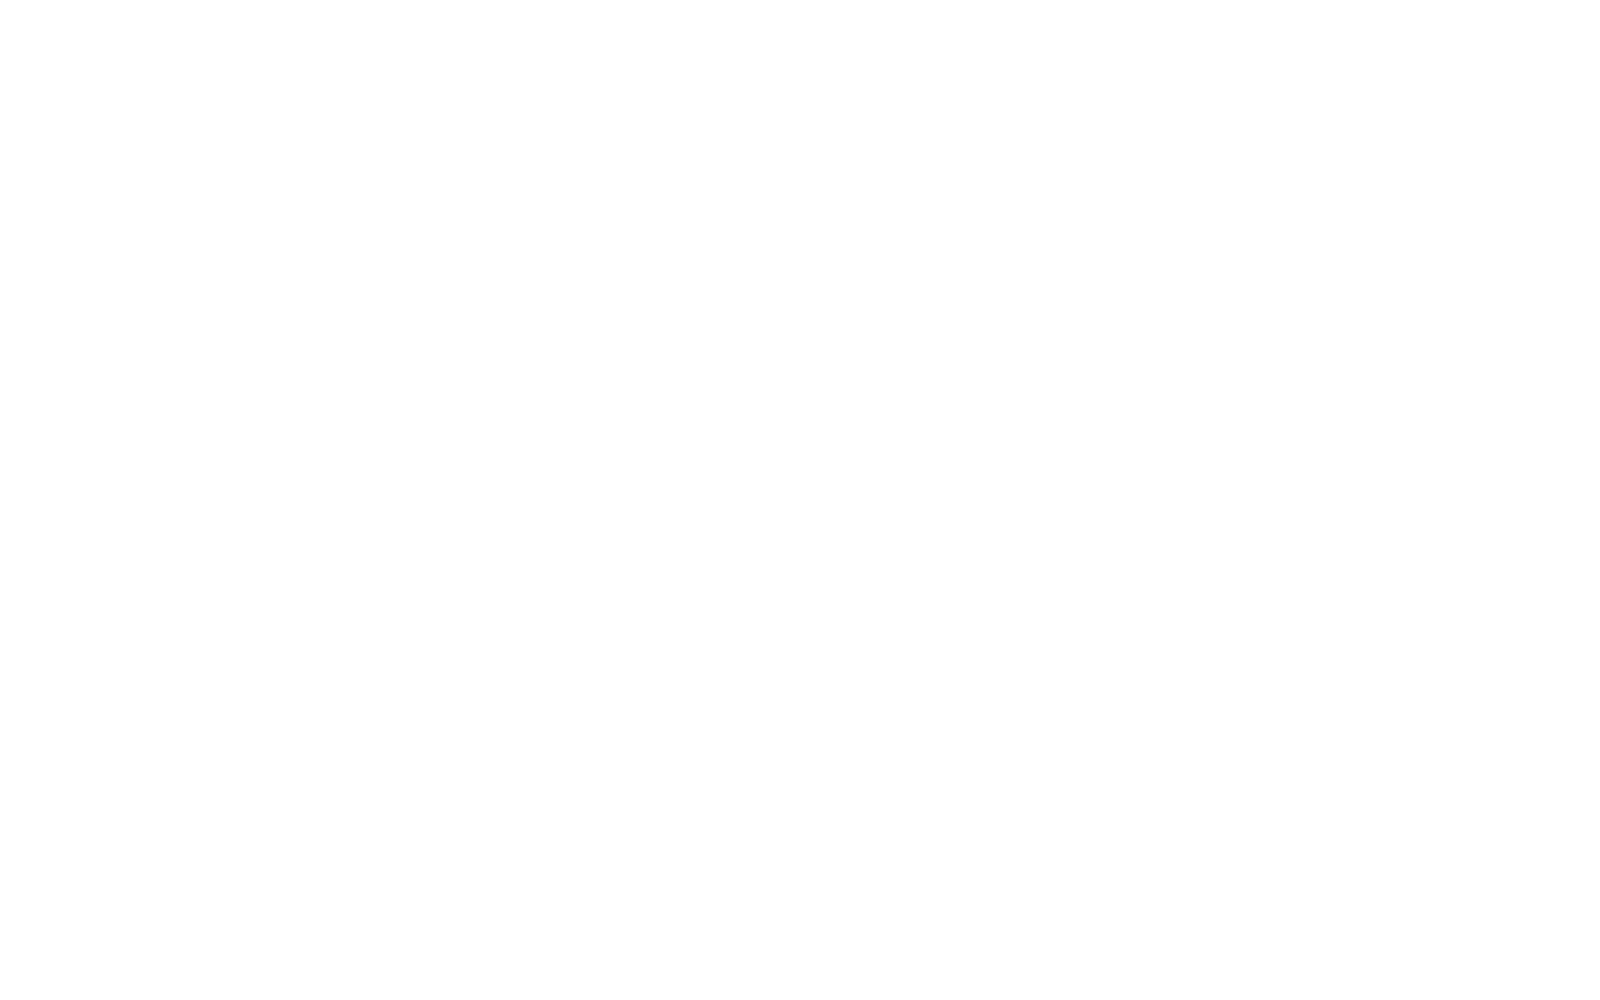

In [5]:
from matplotlib import rc

fig, ax = plt.subplots(figsize=(8, 5))

plt.scatter(x_etv, y_etv, c = x_etv)
plt.errorbar(x_etv, y_etv, yerr = yerr_etv, fmt = '.r')
plt.xlabel("Time (TBJD)", fontsize = 20)
plt.ylabel("Observed - Calculated (mins)", fontsize = 20)
#plt.savefig('/Users/Nora/Desktop/Desktop/ttv_example.png', dpi = 300)
plt.show()

<IPython.core.display.Javascript object>


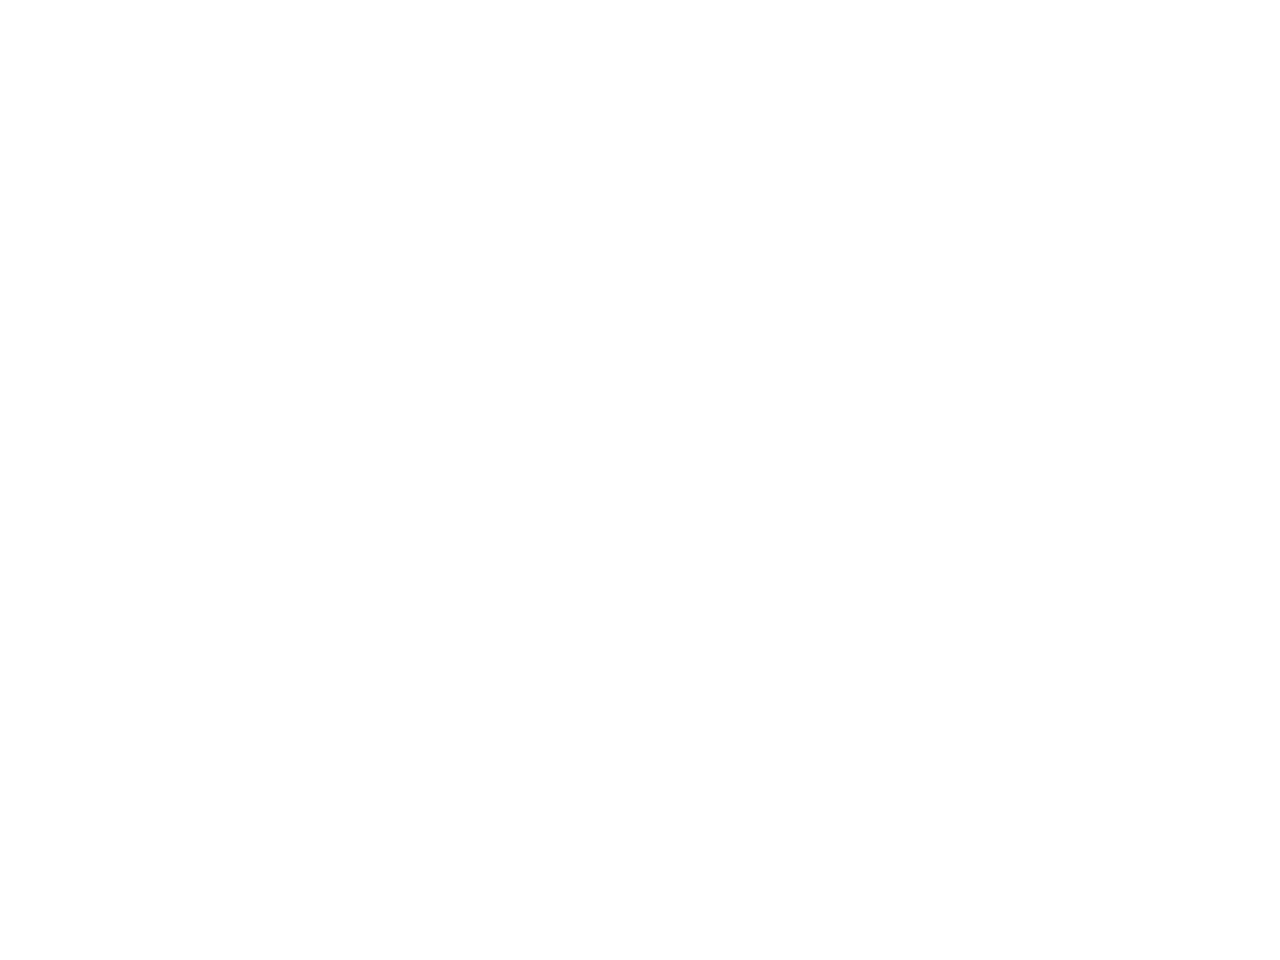

<IPython.core.display.Javascript object>


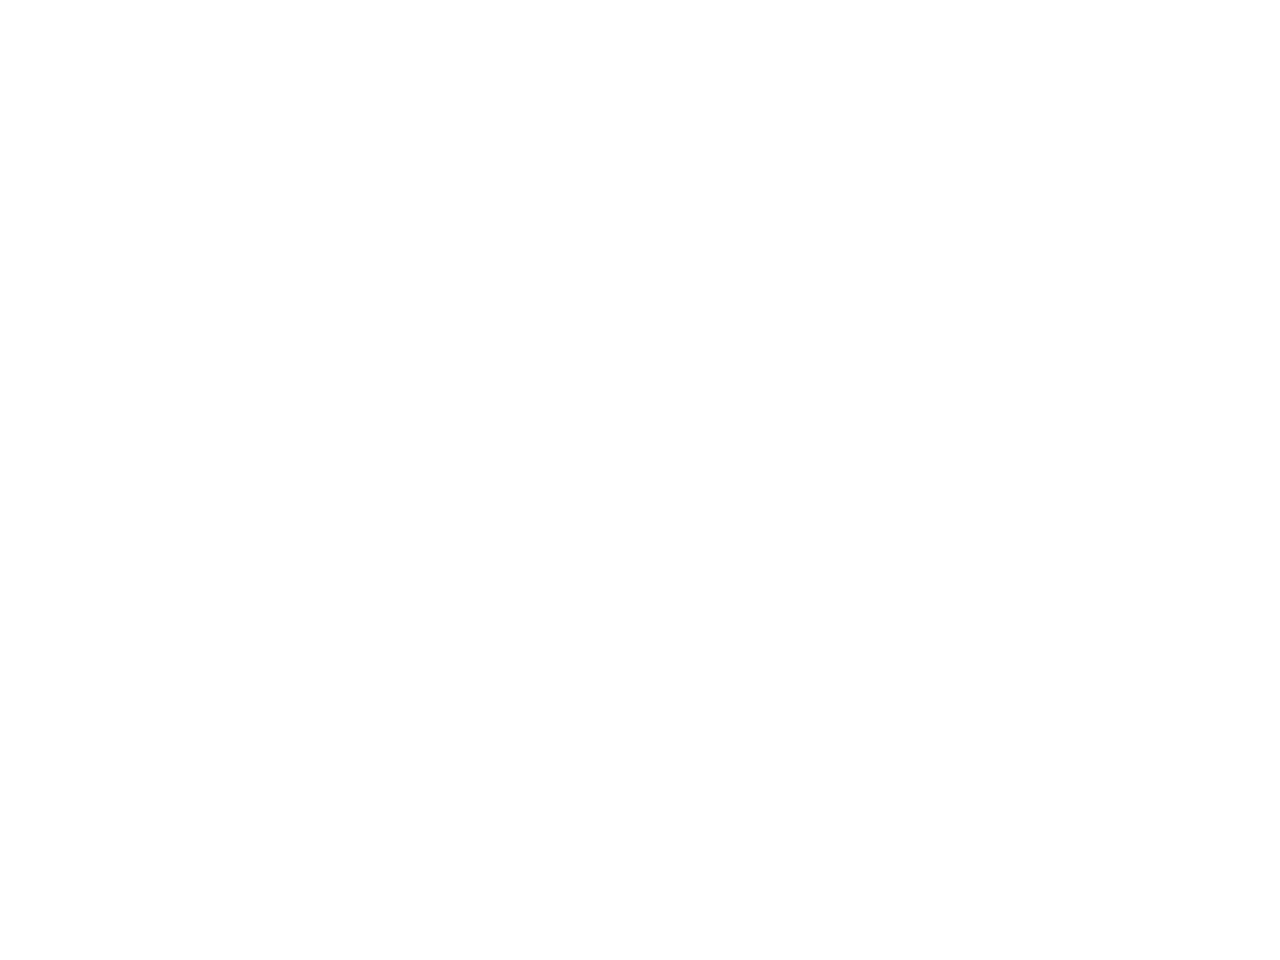

In [6]:
period = 52.6
t0_52 = 1800

phase = np.array([-0.5+( ( t - t0_52-0.5*period) % period) / period for t in x_etv])  

fig, ax = plt.subplots()

plt.scatter(phase, y_etv, c = x_etv)


phase = np.array([-0.5+( ( t - t0_52-0.5*period) % period) / period for t in x])  

fig, ax = plt.subplots()

plt.scatter(phase, y, c = x)


<IPython.core.display.Javascript object>


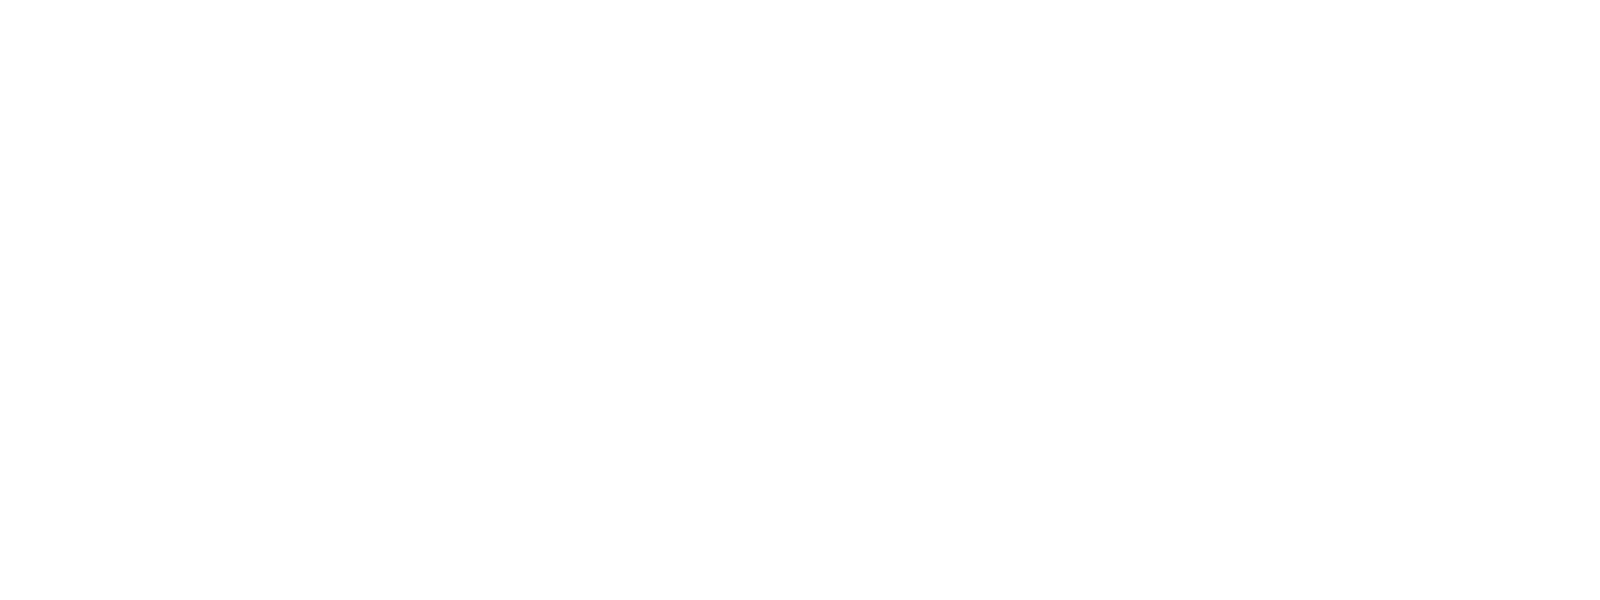

In [7]:
import pymc3 as pm
import theano.tensor as tt

# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (np.nanmin(x) + np.nanmax(x))

# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(np.nanmin(x) - 5, np.nanmax(x) + 5, 1000)

fig, ax = plt.subplots(figsize=(8, 3))

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
_ = plt.ylabel("radial velocity [m/s]")
plt.show()

In [8]:
import exoplanet as xo

periods = [52.6]
period_errs = [2]
t0s = [1878.738] #[1878.1478847143728,1895.00335]
t0_errs = [10]
Ks = [81] #xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[81] m/s


In [9]:
def timetrans_to_timeperi(tc, per, ecc, omega):

    f = np.pi/2 - omega
    ee = 2 * np.arctan(np.tan(f/2) * np.sqrt((1-ecc)/(1+ecc)))  # eccentric anomaly
    tp = tc - per/(2*np.pi) * (ee - ecc*np.sin(ee))      # time of periastron
    
    return tp
    

In [10]:
(359.05 * u.deg).to('rad')

<Quantity 6.26660468 rad>

In [11]:
((-1.12 * u.rad).to("deg")+180*u.deg).to('rad')

<Quantity 2.02159265 rad>

In [12]:
import pymc3 as pm
import theano.tensor as tt
from exoplanet.orbits import get_true_anomaly

P12 = 1.1047115
t012 =  t0
M3 = 15
P4 = 365 * 6

with pm.Model() as model:

    # Gaussian priors based on transit data (from Petigura et al.)
    t03 = pm.Normal("t0", mu=t0s[0], sd=t0_errs[0])
    t04 = pm.Uniform("t04", lower=-3000, upper=3000, testval = -600)
    
    P3 = pm.Bound(pm.Normal, lower=1)("P",mu=52.04,sd=2,testval=52.04)
    
    # Wide log-normal prior for semi-amplitude
    logK = pm.Bound(pm.Normal, lower=0)("logK", mu=np.log(72.168), sd=10, testval=np.log(72.168))
    
    # Eccentricity & argument of periasteron
    #ecc = pm.Normal("ecc", mu = np.array([0.28, 0]), sd =np.array([0.1, 0.1]), shape=2, testval=np.array([0.28, 0.02]))
    
    ecc3 = pm.Bound(pm.Normal, lower=0.2, upper=0.40)('ecc3', mu = 0.3, sd =0.2, testval=0.28)
    ecc4 = pm.Bound(pm.Normal, lower=0.0, upper=0.40)('ecc4', mu = 0.3, sd =0.08, testval=0.3)
    
    omega3 = pm.Uniform("omega", lower = 0, upper = 2*np.pi, testval=5.16)
    omega4 = pm.Uniform("omega4", lower = 0, upper = 2 * np.pi, testval=5.16)
    
    tp3 = pm.Deterministic("tp3", timetrans_to_timeperi(t03, P3, ecc3, omega3))
    
    # Priors
    c0 = pm.Normal("c0",mu=0,sd=5,testval=0)   
    c1 = pm.Normal("c1",mu=0,sd=0.5,testval=0)
    c2 = pm.Normal("c2",mu=0,sd=0.001,testval=-0.0001)

        
    #mass_ratio = pm.Normal("mass_ratio",mu=0.584,sd = 0.137,testval=0.584)
    
    #i_mutual = xo.distributions.Angle("i_mutual", testval= 0.6)
    #g2 = xo.distributions.Angle("g2", testval= -np.pi)
    
    i_mutual = pm.Uniform("i_mutual", lower = 0, upper = np.pi/2,  testval= 0.29)
    
    g2 = pm.Uniform("g2", lower =  0, upper = 2 * np.pi, testval= 6.2666047)
    #g2 = pm.Uniform("g2", lower =  -np.pi, upper = np.pi, testval= -0.05)
    
    asini_ab = pm.Uniform("asini_ab", lower=60, upper=130, testval=91.2)
    
    asini_c = pm.Deterministic("asini_c", (1.9758 * 1e-2) * np.sqrt(1-(ecc3**2)) * np.exp(logK) * P3)
    
    asini4 = pm.Uniform("asini4", lower=100, upper=5000, testval=2000)
    
    #asini_c = (1.9758 * 1e-2) * np.sqrt(1-(ecc3**2)) * np.exp(logK) * P3
    #q_ = asini_ab / asini_c
    #mass_ratio = 1/((1/q_) + 1)
    
    q_ = pm.Deterministic("q_", asini_ab / asini_c)  
    mass_ratio = pm.Deterministic("mass_ratio", 1/((1/q_) + 1))
    
    
    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=0.00000001 ** -np.arange(3)[::-1], shape=3)

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P3, t_periastron=t03, ecc=ecc3, omega=omega3)
    
    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
        pm.Deterministic("vrad" + name, vrad)

        # Define the background model
        A = np.vander(t - x_ref, 3)
        bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, vrad), bkg
    
    # Define the RVs at the observed times
    rv_model, rv_bkg_model = get_rv_model(x)
    
    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred, rv_bkg_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(yerr ** 2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)
    
    
    def etv_dyn(t, P3, tp, ecc3, i_mutual, mass_ratio, g2):
        
        M = tt.zeros_like(tt.constant(t)) + 2.0 * np.pi * (tt.constant(t)) / P3
        true_anom3 = get_true_anomaly(M, ecc3 + tt.zeros_like(M))
        
        MM = ((3. * ecc3 * np.sin(true_anom3)) - ( (3./4.) * (ecc3**2) * (np.sin(2*true_anom3))) + ((1/3.) * (ecc3**3) * (np.sin(3*true_anom3))))
        SS = np.sin((2* true_anom3) + (2*g2)) + (ecc3 * (np.sin(true_anom3 + (2*g2)) + (1/3. * np.sin((3.*true_anom3) + (2 * g2)))))
        
        delta_dyn = (((3. / (4 * np.pi)) * (mass_ratio) * (((P12)**2)/(P3)) * (1. - (ecc3**2))**(-3./2)) *
                    ((((2./3) - (np.sin(i_mutual)**2)) * MM) + (0.5*(np.sin(i_mutual)**2) * SS))) * 1440
        
        return delta_dyn
    
    
    def etv_ltte(t, c0, c1, c2, t012, P12, P3, tp, ecc3, asini, omega3):
        
        E = abs(np.round((t - t012) / P12, 1))

        M = tt.zeros_like(tt.constant(t)) + 2.0 * np.pi * (tt.constant(t)) / P3
        true_anom3 = get_true_anomaly(M, ecc3 + tt.zeros_like(M))
    
        
        # convert from Rsun to m
        asini_m  = asini * 696000000 
        c = 299792458 # m/s
        
        delta_LTTE = - (((asini_m)/c) * (((1 - (ecc3**2.)) * np.sin(true_anom3 + omega3)) / (1 + ecc3*np.cos(true_anom3)))) / 60 # convert from seconds to minutes

        return c0 + (c1*E) + (c2*E**2) + (delta_LTTE)
        
        
    def etv_ltte2(t, t0, P3, P4, ecc4, asini4, omega4):
      
        
        M = tt.zeros_like(tt.constant(t)) + 2.0 * np.pi * (tt.constant(t)) / P4
        true_anom4 = get_true_anomaly(M, ecc4 + tt.zeros_like(M))
      
        # convert from Rsun to m
        asini_m  = asini4 * 696000000 
        c = 299792458 # m/s
      
        delta_LTTE = - (((asini_m)/c) * (((1 - (ecc4**2.)) * np.sin(true_anom4 + omega4)) / (1 + ecc4*np.cos(true_anom4)))) / 60 # convert from seconds to minutes
        
        return delta_LTTE
        

    def etv_model(t, c0, c1, c2, t012, P12, P3, tp, ecc3, omega3, i_mutual, mass_ratio, asini, g2, name=""):
        
        delta_dyn = pm.Deterministic('delta_dyn' + name, etv_dyn(t, P3, tp, ecc3, i_mutual, mass_ratio, g2))
        delta_LTTE = pm.Deterministic('delta_ltte' + name, etv_ltte(t, c0, c1, c2, t012, P12, P3, tp, ecc3, asini, omega3))
        delta_LTTE2 = pm.Deterministic('delta_ltte2' + name, etv_ltte2(t, t04, P3, P4, ecc4, asini4, omega4))
        
        
        return pm.Deterministic("etv_model" + name, delta_dyn + delta_LTTE + delta_LTTE2)
    

    # Expected value of outcome
    x_etv_array = np.arange(np.nanmin(x_etv) - 10, np.nanmax(x_etv) + 10, P12/2)
    
    #etvmodel = pm.Deterministic('etvmodel', etv_model(x_etv, t012, c0, c1, c2, P12, P3, tp, e3, omega3, i_mutual, M123, asini, g2))
    #etvmodel_pred = pm.Deterministic('etvmodel_pred', etv_model(x_etv_array, t012, c0, c1, c2, P12, P3, tp, e3, omega3, i_mutual, M123, asini, g2))
    
    etvmodel = etv_model(x_etv, c0, c1, c2, t012, P12, P3, tp3, ecc3, omega3, i_mutual, mass_ratio, asini_ab, g2)
    etvmodel_pred = etv_model(x_etv_array, c0, c1, c2, t012, P12, P3, tp3, ecc3, omega3, i_mutual, mass_ratio, asini_ab, g2, name = '_pred')
    
    # Condition on the observations
    pm.Normal("obs_etv", mu=etvmodel, sd=yerr_etv, observed=y_etv)


In [13]:
import pymc3_ext as pmx

with model:
    map_params = pmx.optimize()
    

optimizing logp for variables: [trend, logs, asini4, asini_ab, g2, i_mutual, c2, c1, c0, omega4, omega, ecc4, ecc3, logK, P, t04, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -234423.4168373115 -> -329.4104465044228


<IPython.core.display.Javascript object>


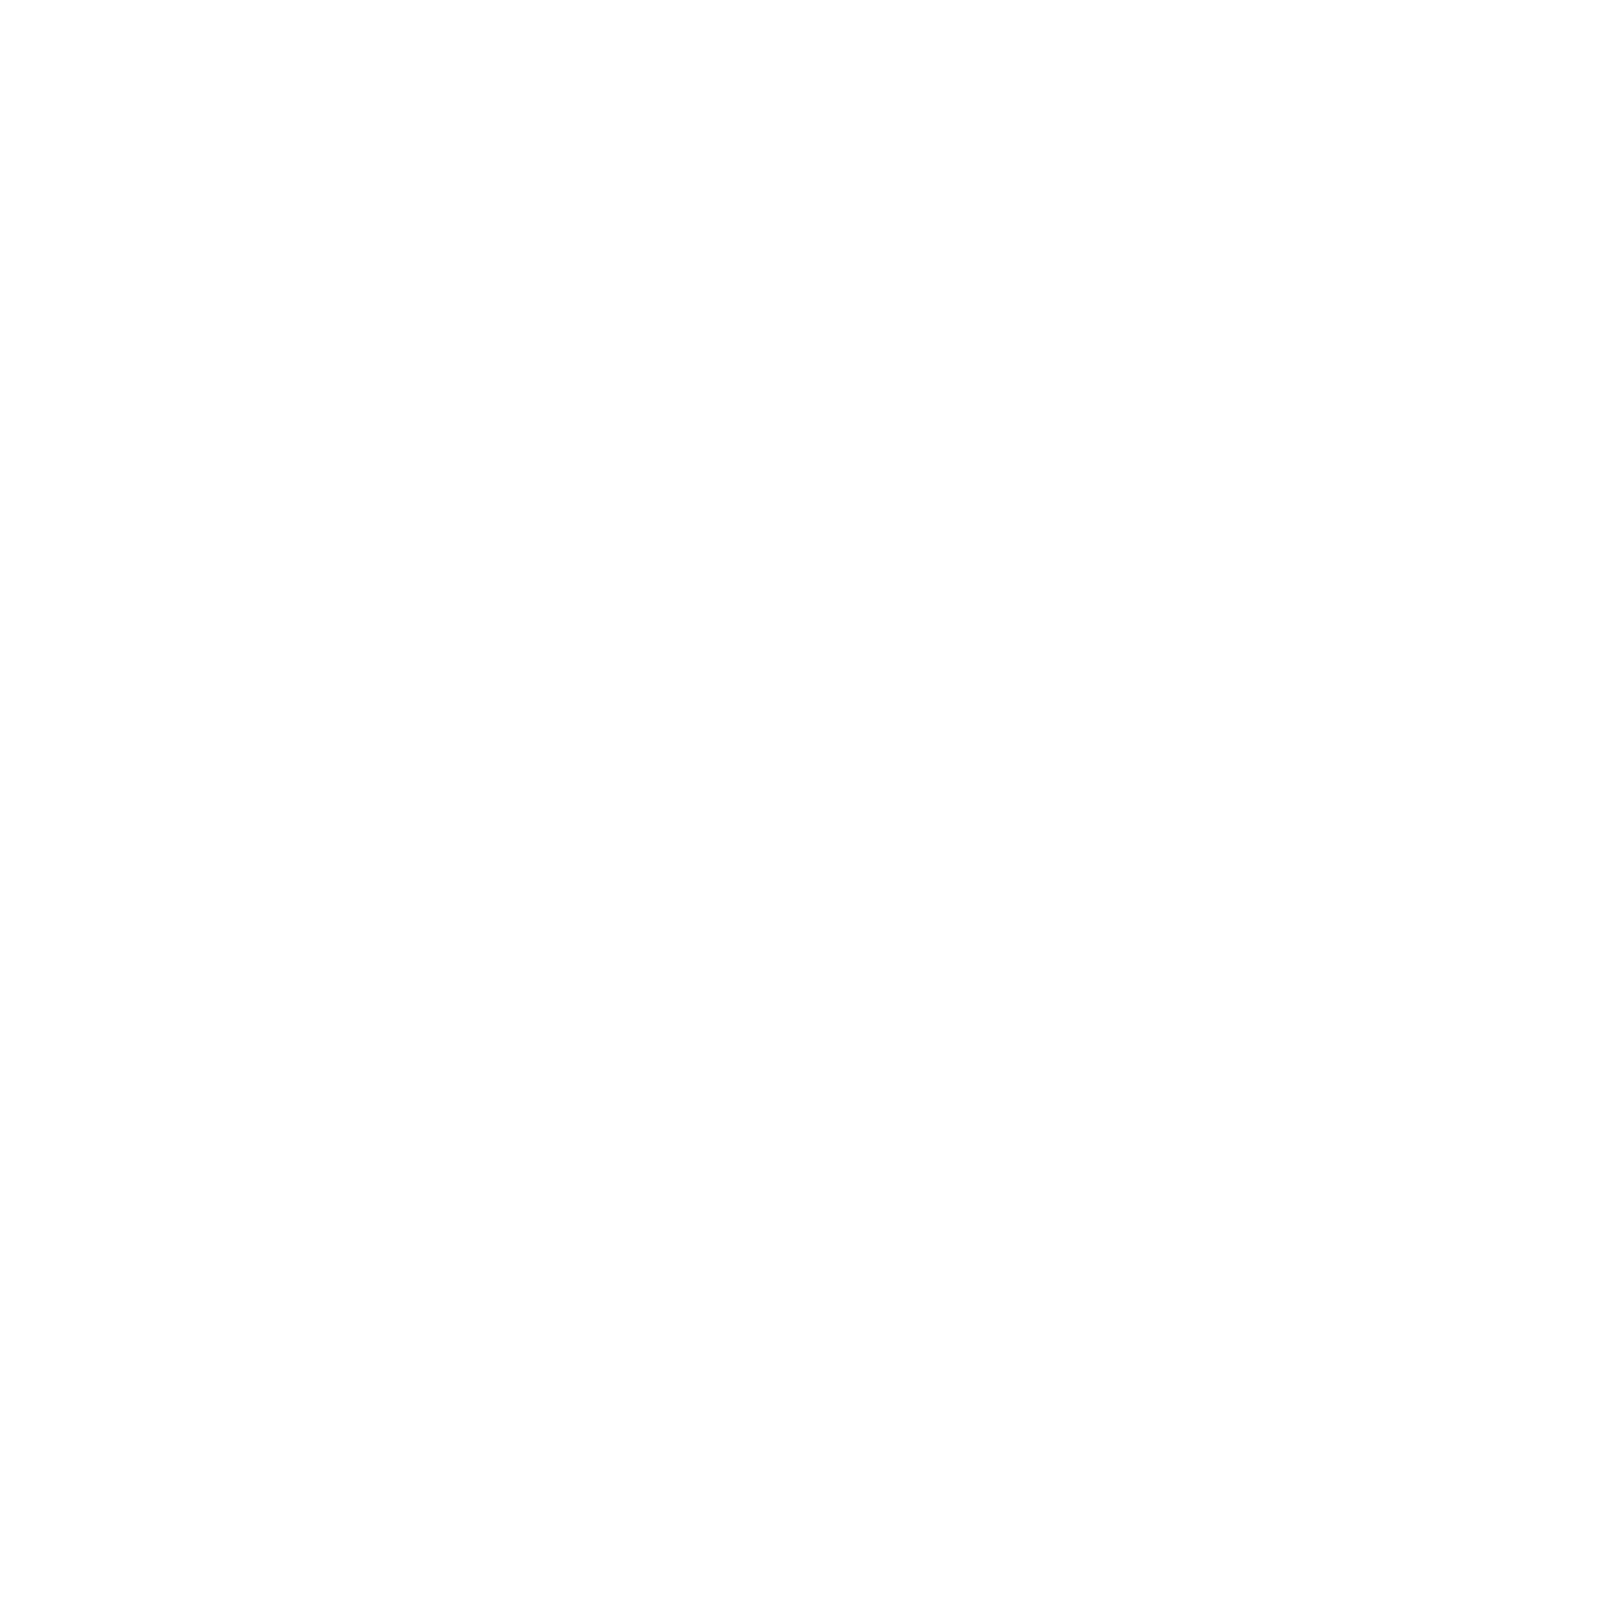

In [14]:
%matplotlib notebook 

fig, ax = plt.subplots(2, 1, figsize=(8, 8))

ax[0].errorbar(x, y, yerr=yerr, fmt=".k")
ax[0].plot(t, map_params["rv_model_pred"], color="C0", lw=1)
ax[0].plot(t, map_params["bkg_pred"], color="r", lw=1)

ax[1].errorbar(x_etv, y_etv, yerr=yerr_etv, fmt=".k")
ax[1].plot(x_etv_array, map_params["etv_model_pred"], color="C0", lw=1)
ax[1].plot(x_etv_array, map_params["delta_dyn_pred"], ls = '--', color="grey", lw=1)
ax[1].plot(x_etv_array, map_params["delta_ltte_pred"], ls = '--', color="grey", lw=1)

#E = abs(np.round((x_etv_array - t012) / P12, 1))
#ax[1].plot(x_etv_array, map_params["c2"]*E**2, ls = '--', color="blue", lw=1)
#ax[1].plot(x_etv_array, map_params["c1"]*E, ls = '--', color="blue", lw=1)



In [15]:
with model:
    map_soln = pmx.optimize(start=model.test_point, vars=[trend])
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [trend]


message: Optimization terminated successfully.
logp: -234423.4168373115 -> -234423.4168373115
optimizing logp for variables: [trend, logs, asini4, asini_ab, g2, i_mutual, c2, c1, c0, omega4, omega, ecc4, ecc3, logK, P, t04, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -234423.4168373115 -> -329.4104465044228


<IPython.core.display.Javascript object>


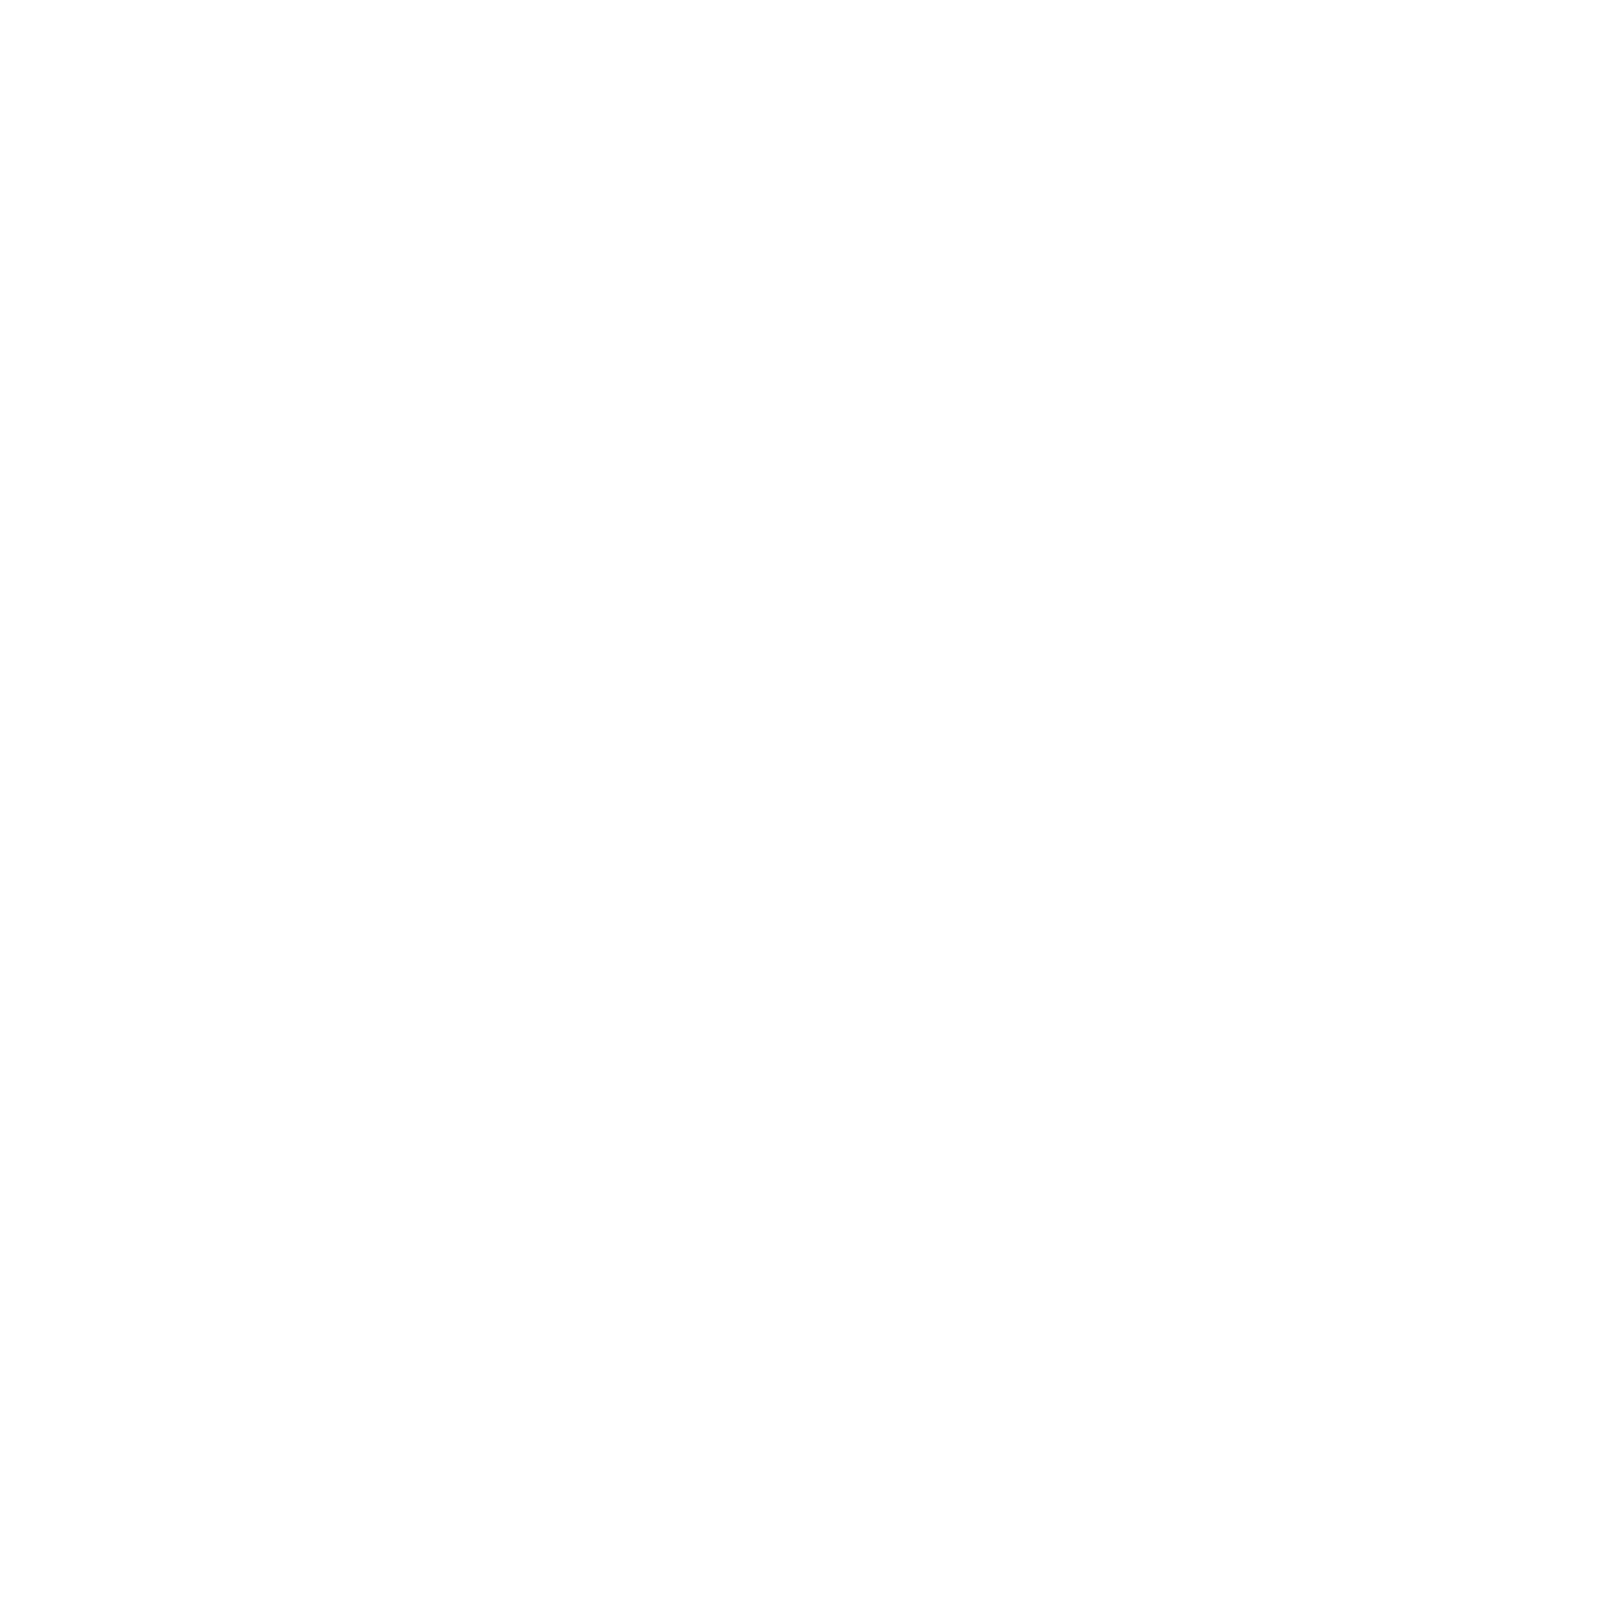

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

ax[0].errorbar(x, y, yerr=yerr, fmt=".k")
ax[0].plot(t, map_soln["rv_model_pred"], color="C0", lw=1)
ax[0].plot(t, map_soln["bkg_pred"], color="r", lw=1)

ax[1].errorbar(x_etv, y_etv, yerr=yerr_etv, fmt=".k")
ax[1].plot(x_etv_array, map_soln["etv_model_pred"], color="C0", lw=1)
ax[1].plot(x_etv_array, map_soln["delta_dyn_pred"], ls = '--', color="grey", lw=1)
ax[1].plot(x_etv_array, map_soln["delta_ltte_pred"], ls = '--', color="grey", lw=1)

In [17]:
for RV in model.basic_RVs:
    print(RV.name, RV.logp(model.test_point))

t0 -3.2215236261987186
t04_interval__ -1.4271163556401456
P_lowerbound__ 2.3205239252719165
logK_lowerbound__ -1.767805051943966
ecc3_interval__ -2.3510548888448186
ecc4_interval__ -0.9834770543422436
omega_interval__ -1.9186488803361257
omega4_interval__ -1.9186488803361257
c0 -2.528376445638773
c1 -0.2257913526447274
c2 5.983816745777465
i_mutual_interval__ -1.8935577517833218
g2_interval__ -5.940040948737759
asini_ab_interval__ -1.3981521426540535
asini4_interval__ -1.438004235392657
logs -2.528376445638773
trend -58.01885783147112
obs -118.89373614085066
obs_etv -234225.26800995012


In [18]:
np.random.seed(42)

with model:
    trace = pm.sample(
        tune=6000,
        draws=6000,
        cores=2,
        chains=2,
        target_accept=0.95,
        init="adapt_full")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [trend, logs, asini4, asini_ab, g2, i_mutual, c2, c1, c0, omega4, omega, ecc4, ecc3, logK, P, t04, t0]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 6_000 tune and 6_000 draw iterations (12_000 + 12_000 draws total) took 706 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 126 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [19]:
trace2 = trace[5000:]

In [20]:
#df = pm.summary(trace2, varnames=["trend", "logs", "omega", "ecc3", "t0", "logK", "P", "c0", "c1", "c2", "mass_ratio", "i_mutual", "g2", "asini"])

df = pm.stats.summary(trace2, var_names=["trend", "logs", "omega", "ecc3", "t0", "logK", "P", "c0", "c1", "c2", "i_mutual", "g2", "asini_ab", "asini_c", "q_","mass_ratio"])

#df = pm.summary(trace2)

#pm.summary(trace2, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P", "mass_ratio", "i_mutual", "g2", "asini"])

Got error No model on context stack. trying to find log_likelihood in translation.


In [21]:
#pm.stats.summary?

In [22]:
df.mean

<bound method NDFrame._add_numeric_operations.<locals>.mean of                     mean            sd        hdi_3%       hdi_97%  \
trend[0]    3.943624e+14  9.996274e+15 -1.872762e+16  1.937244e+16   
trend[1]    2.607042e+06  1.012867e+08 -2.161889e+08  1.808133e+08   
trend[2]   -1.100000e-02  9.880000e-01 -1.872000e+00  1.768000e+00   
logs        2.112000e+00  2.590000e-01  1.591000e+00  2.561000e+00   
omega       5.113000e+00  7.150000e-01  4.221000e+00  6.263000e+00   
ecc3        2.500000e-01  2.900000e-02  2.000000e-01  2.970000e-01   
t0          1.878068e+03  5.509000e+00  1.871087e+03  1.886244e+03   
logK        4.334000e+00  1.040000e-01  4.181000e+00  4.502000e+00   
P           5.296600e+01  4.200000e-01  5.246300e+01  5.342800e+01   
c0          2.470000e+00  4.692000e+00 -6.748000e+00  1.083200e+01   
c1         -2.200000e-02  4.200000e-02 -9.700000e-02  5.000000e-02   
c2          0.000000e+00  0.000000e+00 -0.000000e+00  0.000000e+00   
i_mutual    4.950000e-01  3

In [23]:
varnames=["logs", "omega", "ecc3", "t0", "logK", "P", "c0", "c1", "c2", "i_mutual", "g2", "asini_ab", "mass_ratio", "asini_c", "q_"]
#varnames=["logs", "omega", "ecc3", "t0", "logK", "P", "c0", "c1", "c2", "i_mutual", "g2", "mass_ratio"]


In [24]:
trace2

<MultiTrace: 2 chains, 1000 iterations, 46 variables>

In [25]:
import pymc3.stats as pstats

for var in varnames:
    intvls  = pstats.hdi(trace2[var],1.-0.6827)
    ci_smpl = trace2[var][np.where( ( (trace2[var]>intvls[0]) & (trace2[var]<intvls[1]) ) )[0]]
    
    ci_mdn  = np.nanmedian(trace2[var])
    #print ("{}    :  {}         - {}    + {}".format(var, ci_mdn, ci_mdn - intvls[0],  intvls[1] - ci_mdn))
    print ("{}    =  [{}         , {}   , {}]".format(var, np.round(ci_mdn,5),  np.round(intvls[0],5),  np.round(intvls[1],5)))
    
    

logs    =  [2.11972         , 1.97619   , 2.18911]
omega    =  [4.94894         , 4.32629   , 4.65128]
ecc3    =  [0.24703         , 0.21723   , 0.24257]
t0    =  [1877.52019         , 1871.70884   , 1874.10306]
logK    =  [4.3307         , 4.20377   , 4.26893]
P    =  [53.00554         , 53.361   , 53.40597]
c0    =  [2.5087         , 0.97966   , 4.78092]
c1    =  [-0.02439         , -0.06793   , -0.03116]
c2    =  [2e-05         , 4e-05   , 8e-05]
i_mutual    =  [0.44209         , 0.02675   , 0.28411]
g2    =  [3.0312         , 2.79885   , 3.56046]
asini_ab    =  [68.79508         , 60.00005   , 64.7005]
mass_ratio    =  [0.46697         , 0.41888   , 0.45765]
asini_c    =  [76.54497         , 67.24766   , 71.87563]
q_    =  [0.87608         , 0.70935   , 0.83083]


In [26]:
import pymc3.stats as pstats

for n in range (0,3):
    var = 'trend'

    intvls  = pstats.hdi(trace2[var][:,n],1.-0.6827)
    ci_smpl = trace2[var][:,n][np.where( ( (trace2[var][:,n]>intvls[0]) & (trace2[var][:,n]<intvls[1]) ) )[0]]
    
    ci_mdn  = np.median(trace2[var][:,n])
    
    print ("{}_{}  :  {}         - {}    + {}".format(var, n, ci_mdn, ci_mdn - intvls[0],  intvls[1] - ci_mdn))

trend_0  :  650839574041477.8         - 1539033624186555.8    + 5911670281180249.0
trend_1  :  1484536.0897704659         - 38604969.210315384    + 37565362.3230764
trend_2  :  -0.004464722995071636         - 0.29987167280811633    + 0.4953697470063563


In [27]:
varnames = ["trend", "logs", "omega", "ecc3", "t0", "logK", "P", "c0", "c1", "c2", "mass_ratio", "i_mutual", "g2", "asini_ab"]
units = ["", "", "", "", "", "deg", "", "d", "", "d", "", "", "", "", "deg", "deg", "R$_\odot$", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", "", ""]

count = 0

for i,row in df.iterrows():
    
    varname =  (i)
    varmean =  round(row['mean'], 4)
    upperval = row['hdi_3%']
    lowerval = row['hdi_97%']
    
    err_minus =  round(varmean - lowerval, 5)
    err_plus  =  round(varmean - upperval, 5)
    
    count +=1
    
    print ("\\newcommand {{\{}}}[1][{}]   {{ $ {} _ {{ {} }} ^ {{ {} }}$~#1}}".format(varname, units[count],varmean, err_minus, err_plus))
    
    #\newcommand{\Pb}[1][days]   {$11.6259 _{ - 0.0044 } ^ { + 0.0041 }$~#1} 


\newcommand {\trend[0]}[1][]   { $ 394362350877980.8 _ { -1.8978077013797932e+16 } ^ { 1.9121984838208876e+16 }$~#1}
\newcommand {\trend[1]}[1][]   { $ 2607042.091 _ { -178206242.316 } ^ { 218795911.133 }$~#1}
\newcommand {\trend[2]}[1][]   { $ -0.011 _ { -1.779 } ^ { 1.861 }$~#1}
\newcommand {\logs}[1][]   { $ 2.112 _ { -0.449 } ^ { 0.521 }$~#1}
\newcommand {\omega}[1][deg]   { $ 5.113 _ { -1.15 } ^ { 0.892 }$~#1}
\newcommand {\ecc3}[1][]   { $ 0.25 _ { -0.047 } ^ { 0.05 }$~#1}
\newcommand {\t0}[1][d]   { $ 1878.068 _ { -8.176 } ^ { 6.981 }$~#1}
\newcommand {\logK}[1][]   { $ 4.334 _ { -0.168 } ^ { 0.153 }$~#1}
\newcommand {\P}[1][d]   { $ 52.966 _ { -0.462 } ^ { 0.503 }$~#1}
\newcommand {\c0}[1][]   { $ 2.47 _ { -8.362 } ^ { 9.218 }$~#1}
\newcommand {\c1}[1][]   { $ -0.022 _ { -0.072 } ^ { 0.075 }$~#1}
\newcommand {\c2}[1][]   { $ 0.0 _ { 0.0 } ^ { 0.0 }$~#1}
\newcommand {\i_mutual}[1][]   { $ 0.495 _ { -0.538 } ^ { 0.494 }$~#1}
\newcommand {\g2}[1][deg]   { $ 2.76 _ { -2.89 } ^ { 2.

In [28]:
np.exp(np.mean(trace2.logK))

76.22439987905248

In [29]:
-64.3 + 360

295.7

In [30]:
%matplotlib notebook

In [31]:
import astropy.units as u


asini_ab = np.median(trace2.asini_ab)
asini_ab_l = 81.15550970883817
asini_ab_u = 95.6558070172263  


ecc3 = np.median(trace2.ecc3)
ecc3_l = 0.2875518331399773
ecc3_u = 0.311152261323395

k3 = np.exp(np.mean(trace2.logK))
k3_l = np.exp(4.248926187710056)
k3_u = np.exp(4.28905535405788)

P3 = np.median(trace2.P)
P3_l = 52.02026728940281
P3_u = 52.05343946633533


asini_c = (1.9758 * 1e-2) * np.sqrt(1-(ecc3**2)) * np.exp(logK) * P3


asini3 = (1.9758 * 1e-2) * np.sqrt(1-(ecc3**2)) * k3 * P3
asini3km = (1.3751 * 1e4) * np.sqrt(1-(ecc3**2))  * k3 * P3

asini3_u = (1.9758 * 1e-2) * np.sqrt(1-(ecc3_u**2)) * k3_u * P3_u
asini3km_u = (1.3751 * 1e4) * np.sqrt(1-(ecc3_u**2))  * k3_u * P3_u

asini3_l = (1.9758 * 1e-2) * np.sqrt(1-(ecc3_l**2)) * k3_l * P3_l
asini3km_l = (1.3751 * 1e4) * np.sqrt(1-(ecc3_l**2))  * k3_l * P3_l

q_ =  asini3 / asini_ab

#print (asini_ab, asini3)

q_u =  asini3_l /asini_ab_u
q_l = asini3_u /asini_ab_l

mass_ratio = 1/((1/q_) + 1)
mass_ratio_u = 1/((1/q_l) + 1)
mass_ratio_l = 1/((1/q_u) + 1)


print (" asini_c: {} + {} - {}".format(asini3, asini3_u - asini3, asini3 - asini3_l))

#print ("asini_c{} + {} - {}".format(asini3km, asini3km_u - asini3km,asini3km -  asini3km_l))

print ("q: {} + {} - {}".format(q_, mass_ratio_u - q_,q_ -  mass_ratio_l))

print ("mass ratio: {} + {} - {}".format(mass_ratio, mass_ratio_u - mass_ratio,mass_ratio -  mass_ratio_l))

 asini_c: 77.35459787852062 + -6.103154299944535 - 8.416427153387474
q: 1.1244205438331223 + -0.6569127166527726 - 0.7055827973328054
mass ratio: 0.52928340723175 + -0.061775580051400325 - 0.11044566073143314


In [32]:
def calculate_K_from_RV(ecc,asini,Porb):
    # Calculates semi-amplitude K according to asini
    # asini in Rsun
    # Porb in days
    # Returns K in km/s
    # eq --> K = asini / [(1.9758e-2) * sqrt(1 - ecc^2) * Porb]
    return asini / ( (1.9758e-2) * np.sqrt(1-ecc**2) * Porb )

def calculate_msin3i(ecc,K1,K2,Porb):
    # Calculates msin3i according to RV variations
    # K in km/s
    # Porb in days
    # Returns m1sin3i and m2sin3i in Msun
    # eq --> m_1_sin3i = (1.0361e-7) * (1 - ecc^2)^1.5 * (K1+K2)^2 * K2 * Porb
    # eq --> m_2_sin3i = (1.0361e-7) * (1 - ecc^2)^1.5 * (K1+K2)^2 * K1 * Porb

    m1sin3i = (1.0361e-7) * ((1-ecc**2)**1.5) * ((K1+K2)**2) * K2 * Porb
    m2sin3i = (1.0361e-7) * ((1-ecc**2)**1.5) * ((K1+K2)**2) * K1 * Porb

    return m1sin3i, m2sin3i

def calculate_asini_from_RV(ecc,K,Porb):
    # Calculates asini according to RV variations
    # K in km/s
    # Porb in days
    # Returns asini in Rsun
    # eq --> asini = (1.9758e-2) * sqrt(1 - ecc^2) * K * Porb
    return (1.9758e-2) * np.sqrt(1-(ecc**2)) * K * Porb


# Parameters of the wide orbit -- AB + C
# AB is the 1.1047 d EB
# C is an early B-type star


logs    =  [4.25023         , 4.18892   , 4.31467]
omega    =  [-1.12841         , -1.23798   , -1.08058]
ecc3    =  [0.27379         , 0.25944   , 0.28153]
t0    =  [1879.87634         , 1879.44422   , 1880.36946]
logK    =  [4.28437         , 4.27565   , 4.30344]
P    =  [52.403         , 52.35426   , 52.41858]
c0    =  [1.1419         , 0.72272   , 1.60066]
c1    =  [-0.0018         , -0.00813   , 0.00175]
c2    =  [0.0         , -0.0   , 1e-05]
i_mutual    =  [0.50267         , 0.39796   , 0.64812]
g2    =  [-0.04419         , -1.59454   , 0.27546]
asini_ab    =  [66.19893         , 51.1806   , 60.80868]
mass_ratio    =  [0.47794         , 0.42448   , 0.46813]
asini_c    =  [72.2984         , 71.36364   , 73.26364]
q_    =  [0.91549         , 0.7185   , 0.85953]

P_AB_C = P[0] * u.d # period of the tertiary (from both)
P_AB_C_l = P[1] * u.d
P_AB_C_u = P[2] * u.d

ecc_AB_C =   ecc3[0] # eccentricity of the outer system  (from both)
ecc_AB_C_l = ecc3[1]
ecc_AB_C_u = ecc3[2]

K_C =   np.exp(logK[0]) * u.km / u.second # semi amplitude of the outer system (from RVs)
K_C_l = np.exp(logK[1]) * u.km / u.second
K_C_u = np.exp(logK[2]) * u.km / u.second

a_AB_sini =   asini_ab[0] * u.Rsun
a_AB_sini_l = asini_ab[1]* u.Rsun
a_AB_sini_u = asini_ab[2]* u.Rsun

a_C_sini = calculate_asini_from_RV(ecc_AB_C,K_C.value,P_AB_C.value)*u.Rsun

a_C_sini_l = calculate_asini_from_RV(ecc_AB_C_l,K_C_l.value,P_AB_C_l.value)*u.Rsun
a_C_sini_u = calculate_asini_from_RV(ecc_AB_C_u,K_C_u.value,P_AB_C_u.value)*u.Rsun

# print (P_AB_C, ecc_AB_C, K_C, a_AB_sini, a_C_sini)

K_AB = calculate_K_from_RV(ecc_AB_C, a_AB_sini.value, P_AB_C.value) * u.km / u.second

K_AB_l = calculate_K_from_RV(ecc_AB_C_l, a_AB_sini_l.value, P_AB_C_l.value) * u.km / u.second
K_AB_u = calculate_K_from_RV(ecc_AB_C_u, a_AB_sini_u.value, P_AB_C_u.value) * u.km / u.second


m1sin3i,m2sin3i = calculate_msin3i(ecc_AB_C,K_C.value,K_AB.value,P_AB_C.value)


m1sin3i_l,m2sin3i_l = calculate_msin3i(ecc_AB_C_l,K_C_l.value,K_AB_l.value,P_AB_C_l.value)
m1sin3i_u,m2sin3i_u = calculate_msin3i(ecc_AB_C_u,K_C_u.value,K_AB_u.value,P_AB_C_u.value)

print ()

print('M1sin3i = {}  - {}  + {}'.format(m1sin3i, m1sin3i - m1sin3i_l, m1sin3i_u - m1sin3i))
print('M2sin3i = {}  - {}  + {}  '.format(m2sin3i, m2sin3i -m2sin3i_l, m2sin3i_u - m2sin3i))
print ()

print('a_ABC   = {}'.format( (a_AB_sini + a_C_sini).to('AU')))

print ()

print('A_c/A_ab = {} / {} = {}'.format(a_C_sini, a_AB_sini, a_C_sini/a_AB_sini))

#52.04412265384849 d 0.2997206179779378 72.15401780619199 km / s 91.21882916924386 solRad 70.78412471712365 solRad


M1sin3i = 6.207418429511426  - 2.4104814063660043  + -0.845218992186128
M2sin3i = 6.775127342649437  - 1.4444414141504751  + -0.2942384979884398  

a_ABC   = 0.6438673490695479 AU

A_c/A_ab = 72.25325403630589 solRad / 66.19893 solRad = 1.091456524090433


In [33]:
print(14 * 0.7776)
print(17 * 0.7776)

10.8864
13.219199999999999


In [34]:
np.sin(5.036)**3 * 14

-11.931122469264906

In [35]:
# M1 has to range between 14 and 17
# minimum mass of M1 is 11.87 because M1sin^3i = 11.87
# asssume that M1 = 14, then sin^i = 11.87/14, therefore i = sin-3(11.87/14)
#inclination_min = np.sin-3(11.87/14)

In [36]:
#print ("minimum inclination:")
#x = ((np.arcsin((11.87/14)**(1/3.))))
#print (x)
#print(np.degrees(x)) 
#
#print()
#print ("maximim inclination:")
#x = ((np.arcsin((11.87/17)**(1/3.))))
#print (x)
#print(np.degrees(x)) 


#print (14*np.sin(x)**3)

In [37]:
#maximum period for a hard binary 

#(((np.pi* c.G)/np.sqrt(2)) * ((m1* m2)/m3) **(3/2)) *  (m1 + m2)**(-0.5) * 

In [38]:
# stability criterion

# ~4 solar mass star MS lifetime
# ~ 15 solar mass star MS lifetime

In [39]:
import corner

In [40]:

samples = pm.trace_to_dataframe(trace2, varnames=["trend", "logs", "omega", "ecc3", "t0", "logK", "P", "c0", "c1", "c2", "i_mutual", "g2", "asini_ab", "asini_c", "q_","mass_ratio"])
#samples = pm.trace_to_dataframe(trace2, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P", "mass_ratio", "i_mutual", "g2", "asini"])

_ = corner.corner(samples, quantiles=[0.16, 0.5, 0.84])

Pandas support in corner is deprecated; use ArviZ directly


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


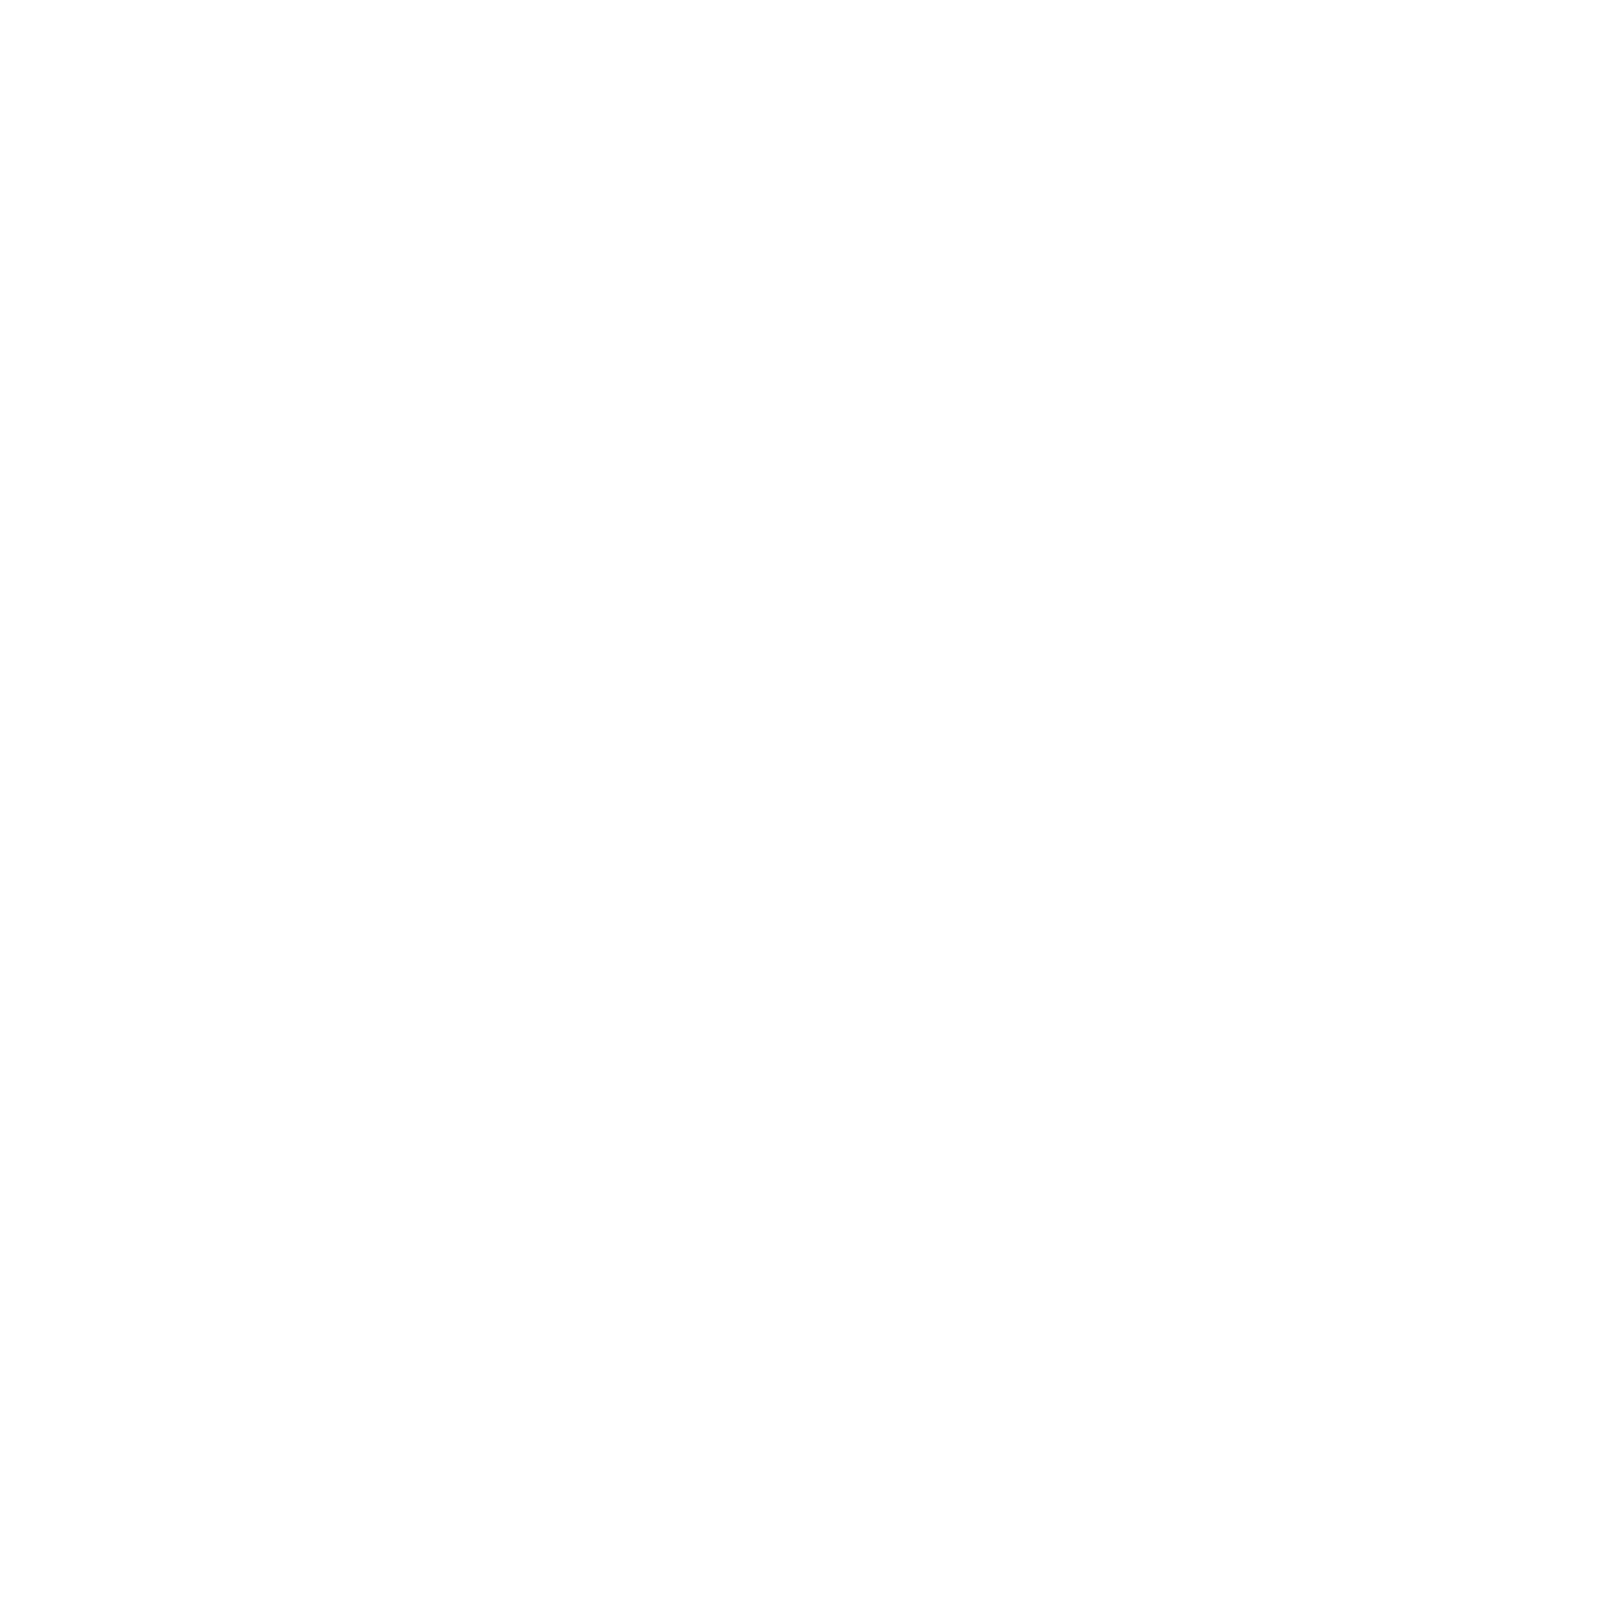

In [41]:
%matplotlib notebook
fig, ax = plt.subplots(2,1, figsize=(8,8))

ax[0].errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace2["rv_model_pred"], [16, 50, 84], axis=0)
ax[0].plot(t, pred[1], color="C0", label="model")
art = ax[0].fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

#ax[0].legend(fontsize=10)
ax[0].set_xlim(t.min(), t.max())
ax[0].set_xlabel("time [days]")
ax[0].set_ylabel("radial velocity [m/s]")
#_ = ax[0].set_title("posterior constraints")


# Compute the posterior predictions for the RV model
ax[1].errorbar(x_etv, y_etv, yerr=yerr_etv, fmt=".k")

pred = np.percentile(trace2["etv_model_pred"], [16, 50, 84], axis=0)
ax[1].plot(x_etv_array, pred[1], color="darkorange", label="model", lw = 2, zorder = 10)
#art = ax[1].fill_between(x_etv_array, pred[0], pred[2], color="darkorange", alpha=0.3)
#art.set_edgecolor("none")

pred = np.percentile(trace2["delta_dyn_pred"], [16, 50, 84], axis=0)
ax[1].plot(x_etv_array, pred[1], color="grey", label="model", ls = '--', lw = 1)
#art = ax[1].fill_between(x_etv_array, pred[0], pred[2], color="grey", alpha=0.3)
#art.set_edgecolor("none")

pred = np.percentile(trace2["delta_ltte_pred"], [16, 50, 84], axis=0)
ax[1].plot(x_etv_array, pred[1], color="gold", label="model", ls = '--', lw = 1)
#art = ax[1].fill_between(x_etv_array, pred[0], pred[2], color="gold", alpha=0.3)
#art.set_edgecolor("none")

#ax[1].axhline(0)
#delta_dyn
#delta_ltte
#ax[1].legend(fontsize=10)

ax[1].set_xlim(x_etv_array.min(), x_etv_array.max())
ax[1].set_xlabel("time [days]")
ax[1].set_ylabel("radial velocity [m/s]")
#_ = ax[1].set_title("posterior constraints")

plt.show()


[[-1.58385236e+20 -1.57751695e+20 -1.57119425e+20 ... -1.57119425e+20
  -1.57751695e+20 -1.58385236e+20]
 [ 1.07639086e+19  1.07208530e+19  1.06778837e+19 ...  1.06778837e+19
   1.07208530e+19  1.07639086e+19]
 [ 1.67785277e+20  1.67114136e+20  1.66444341e+20 ...  1.66444341e+20
   1.67114136e+20  1.67785277e+20]]


<IPython.core.display.Javascript object>


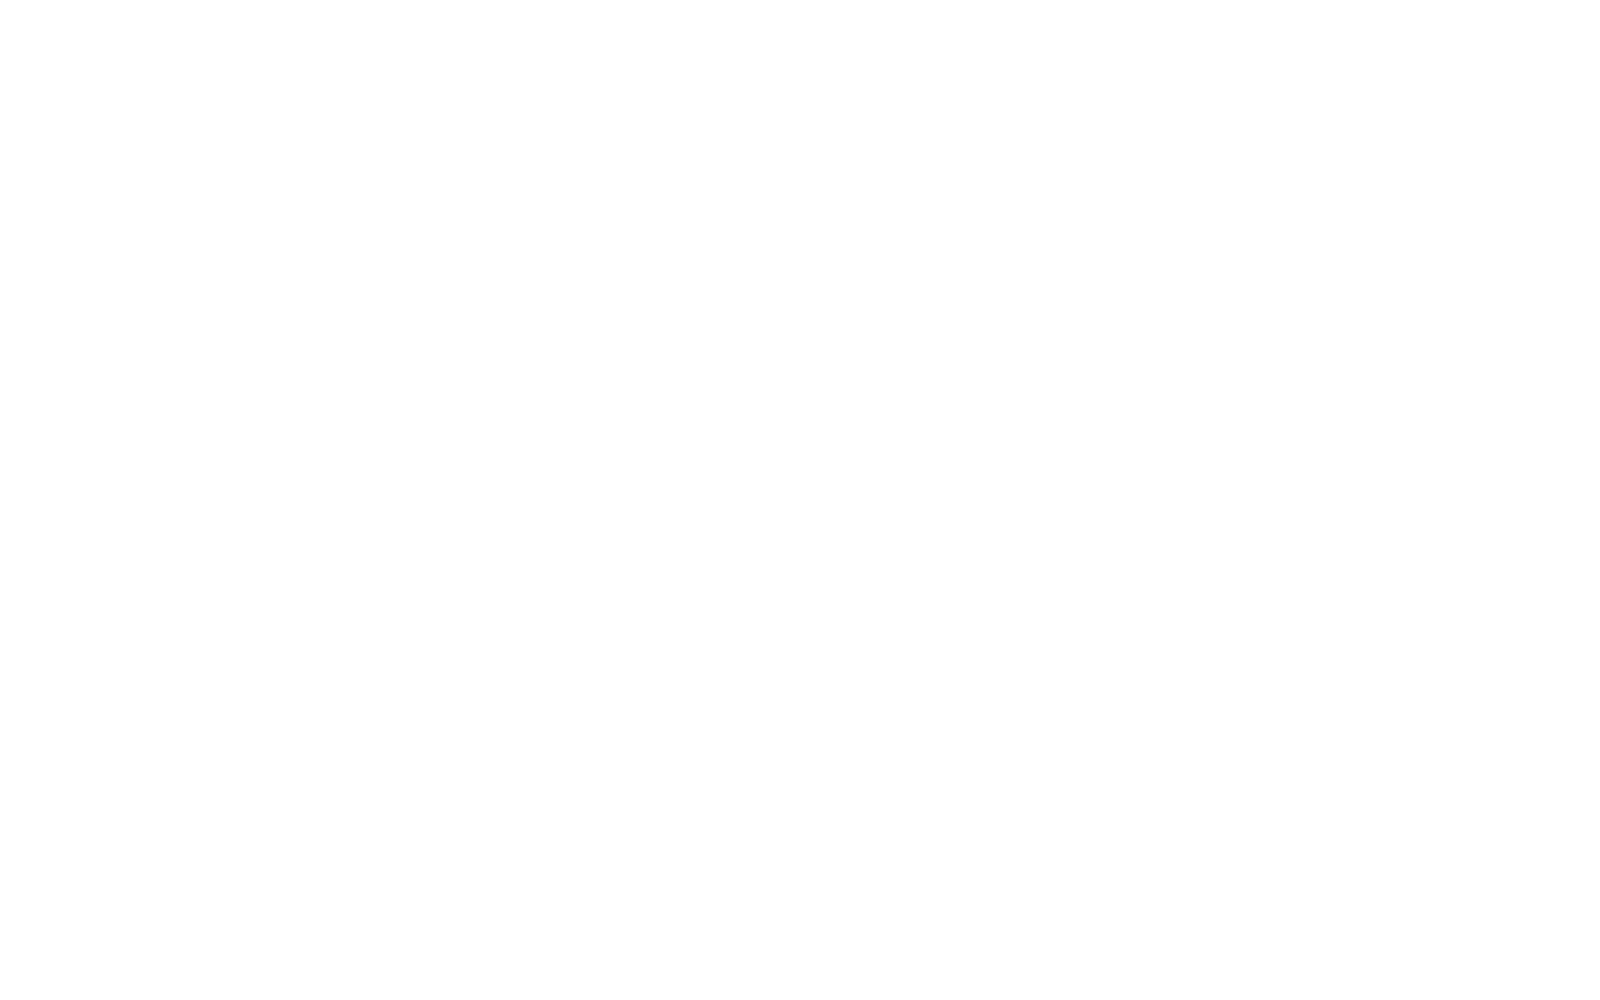

<IPython.core.display.Javascript object>


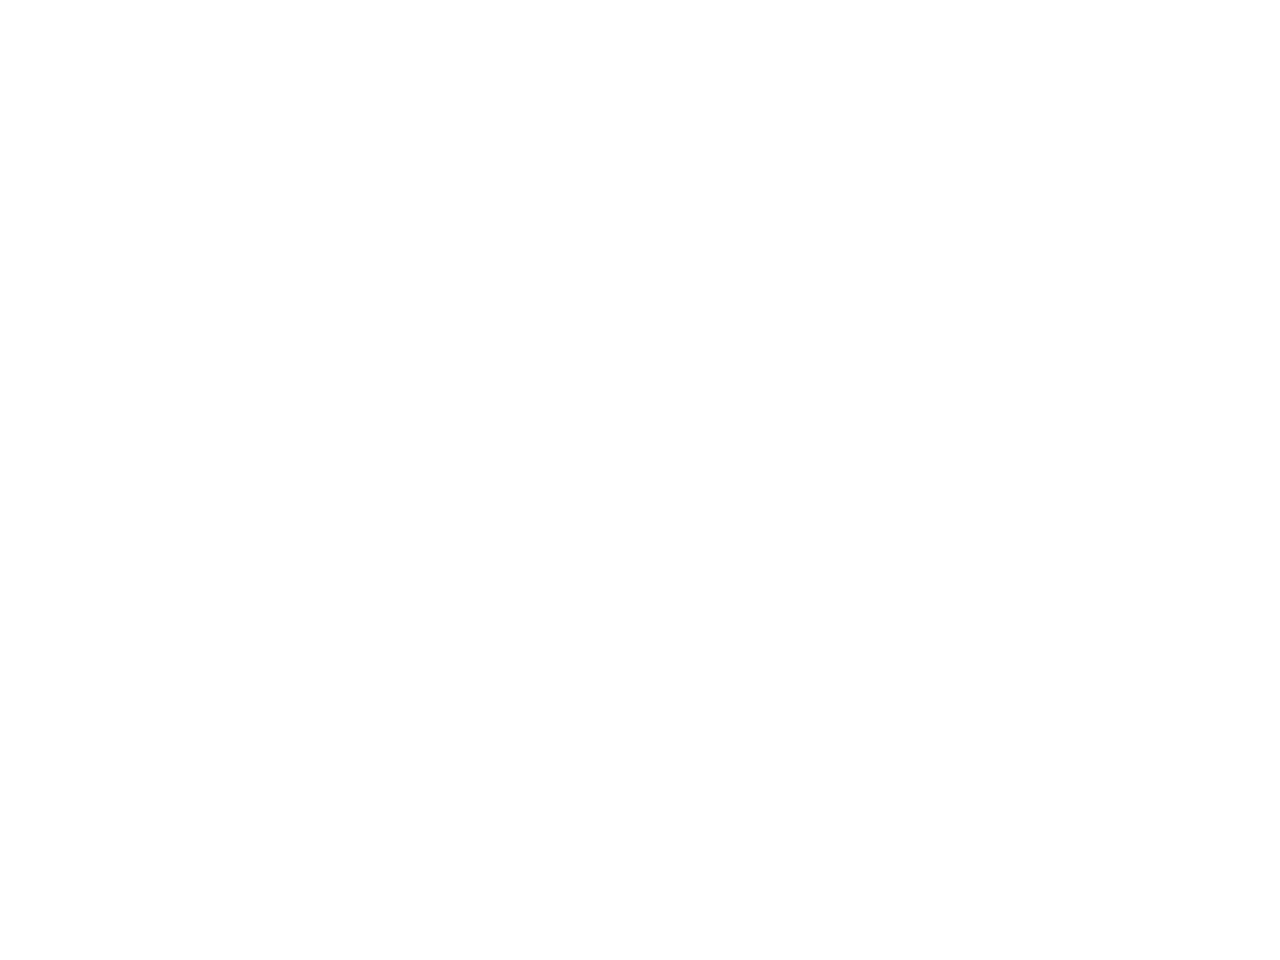

<IPython.core.display.Javascript object>


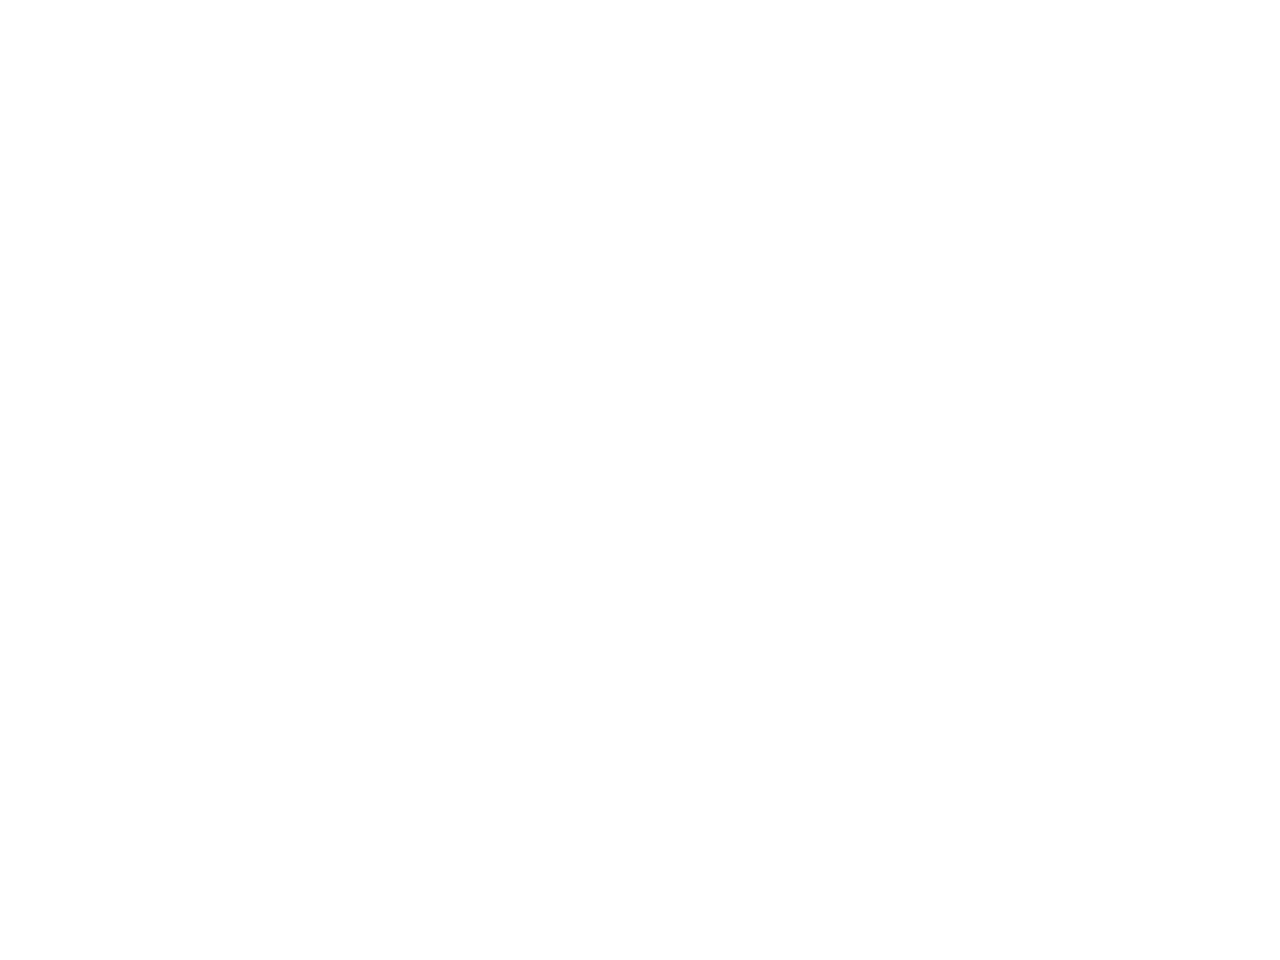

<IPython.core.display.Javascript object>


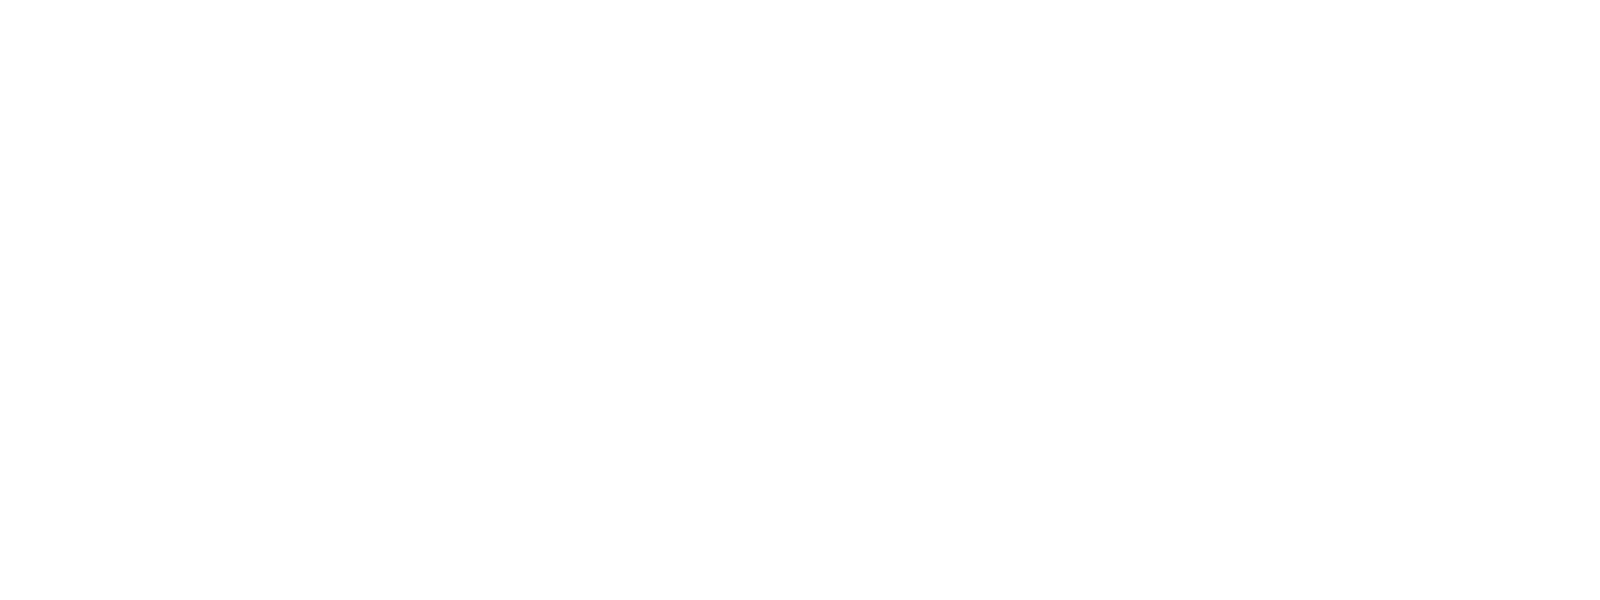

<IPython.core.display.Javascript object>


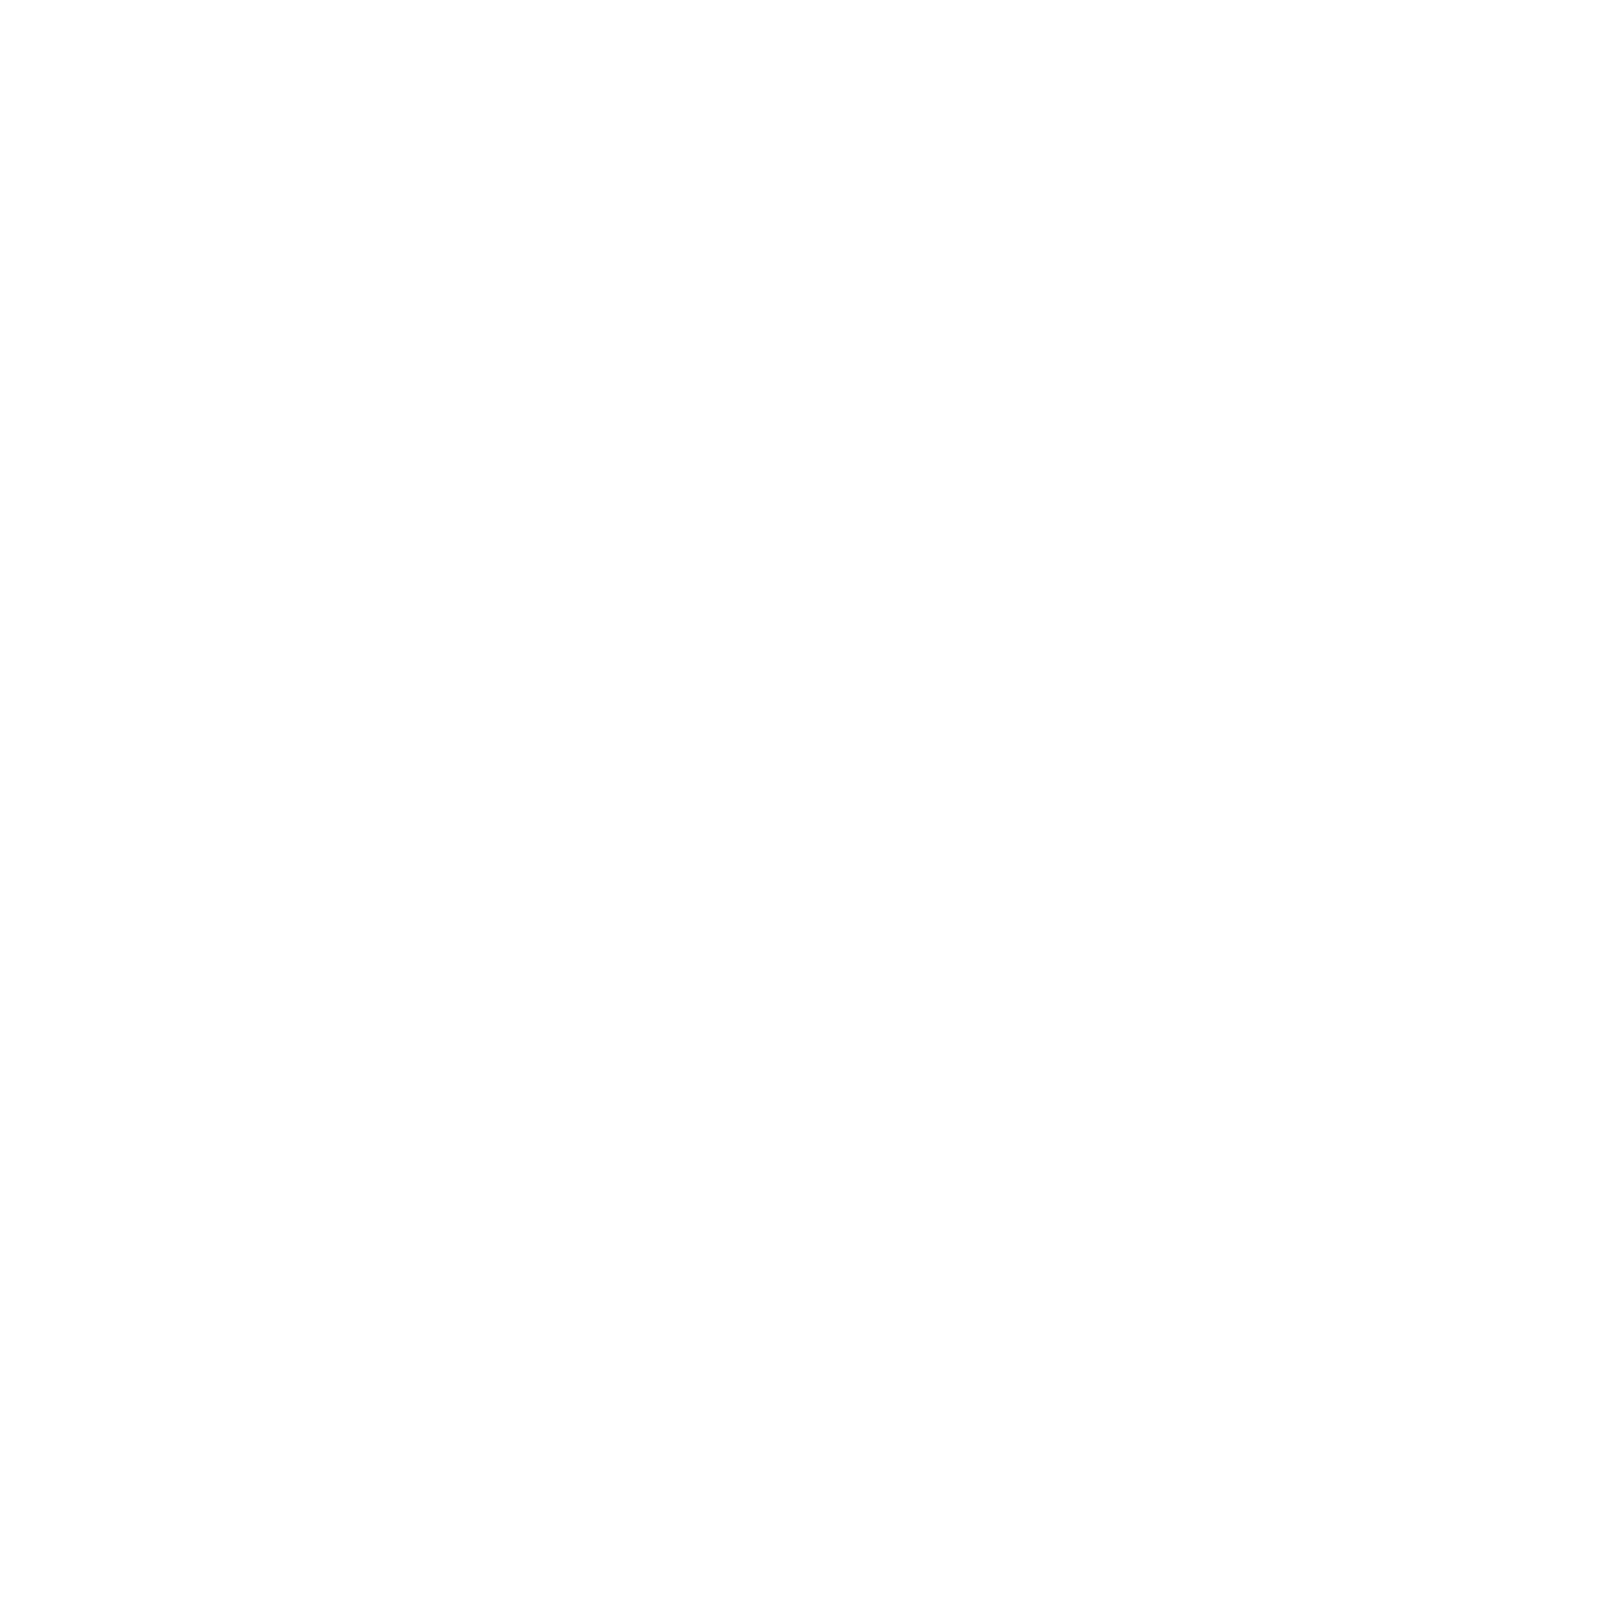

<IPython.core.display.Javascript object>


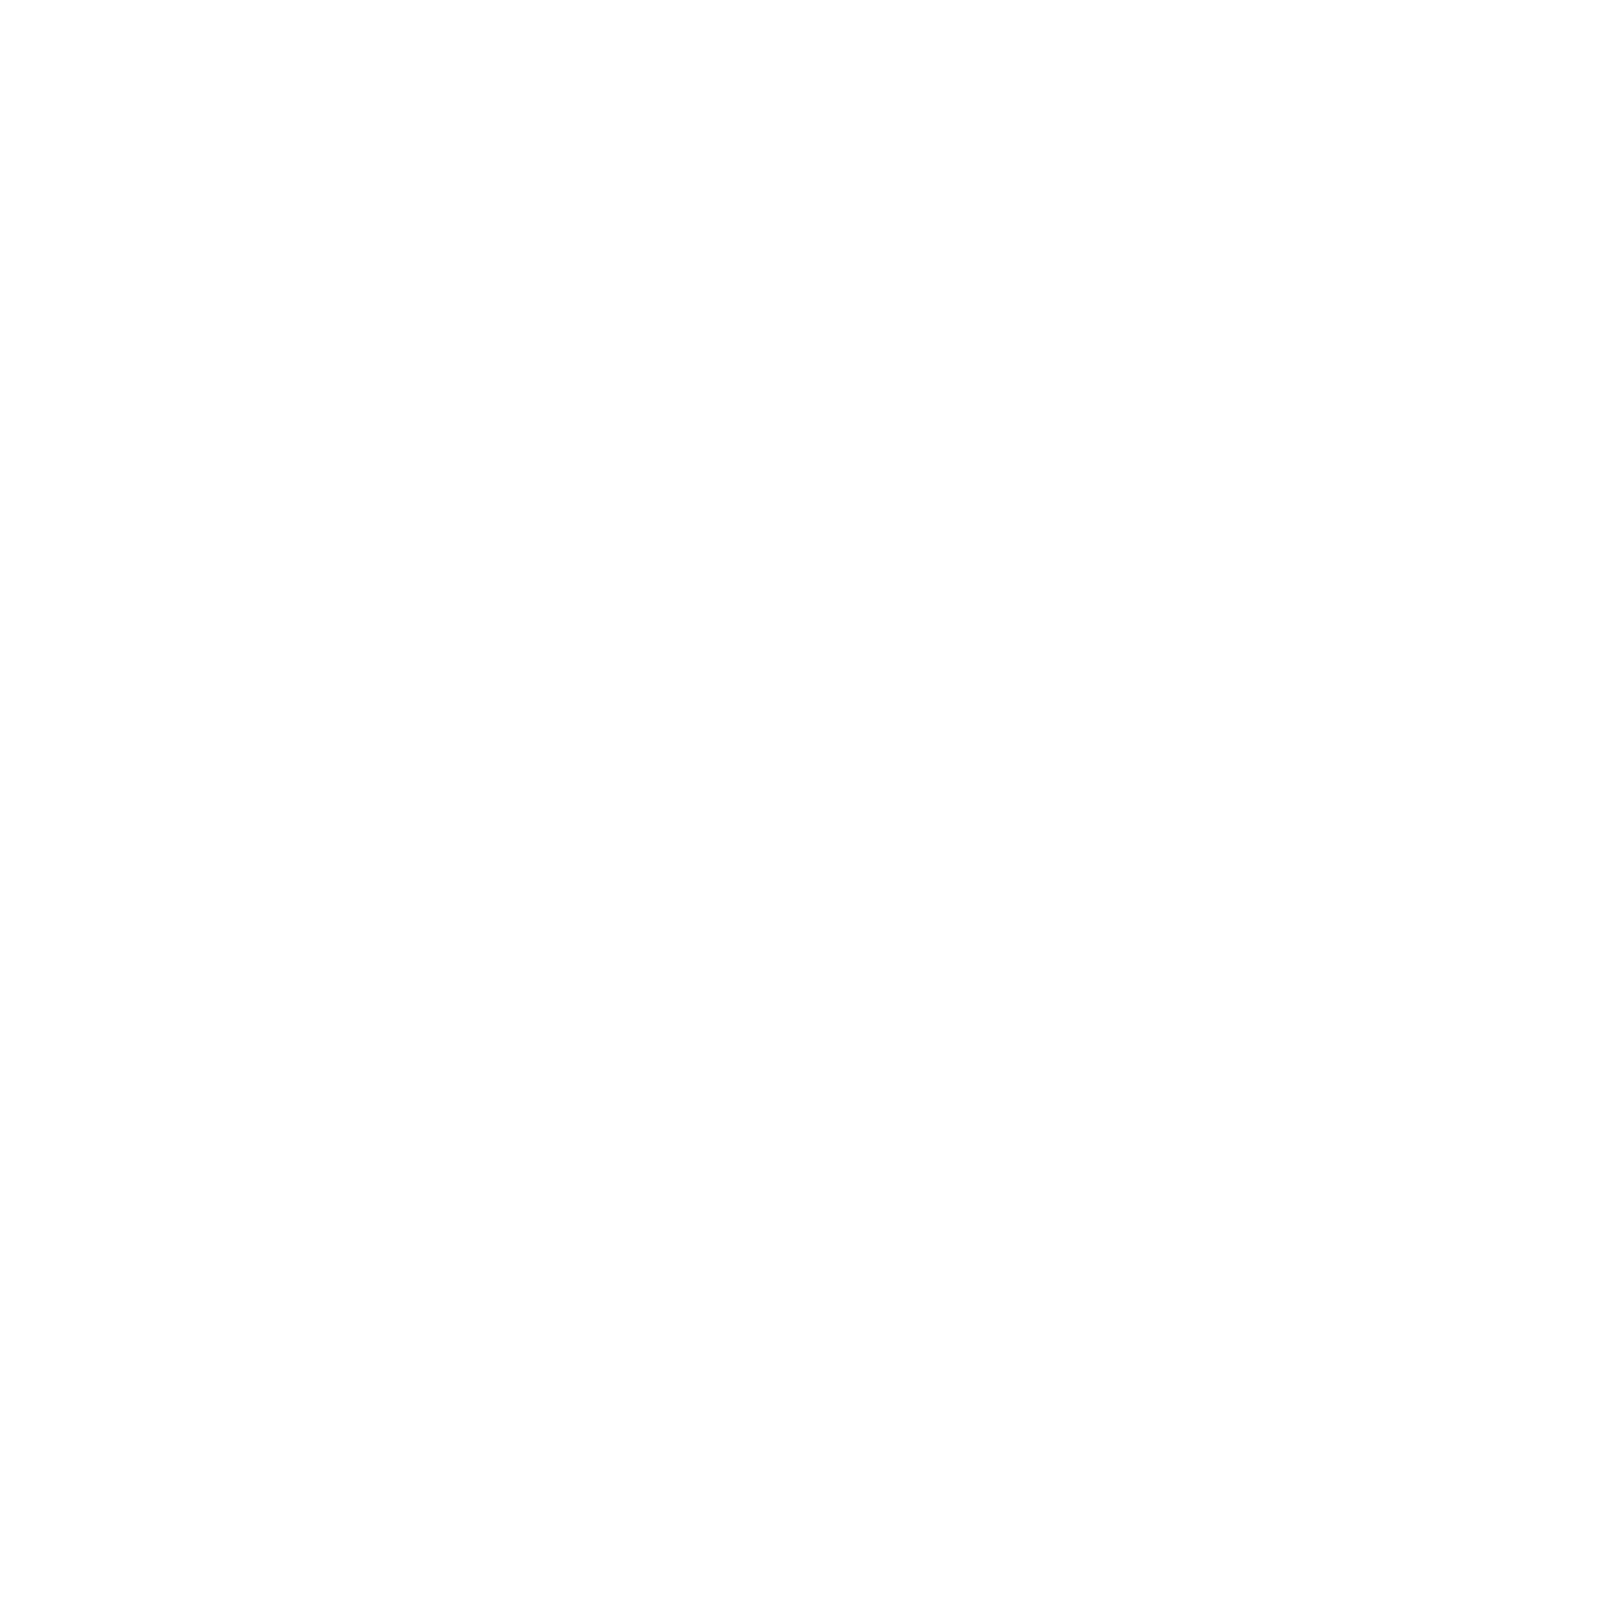

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


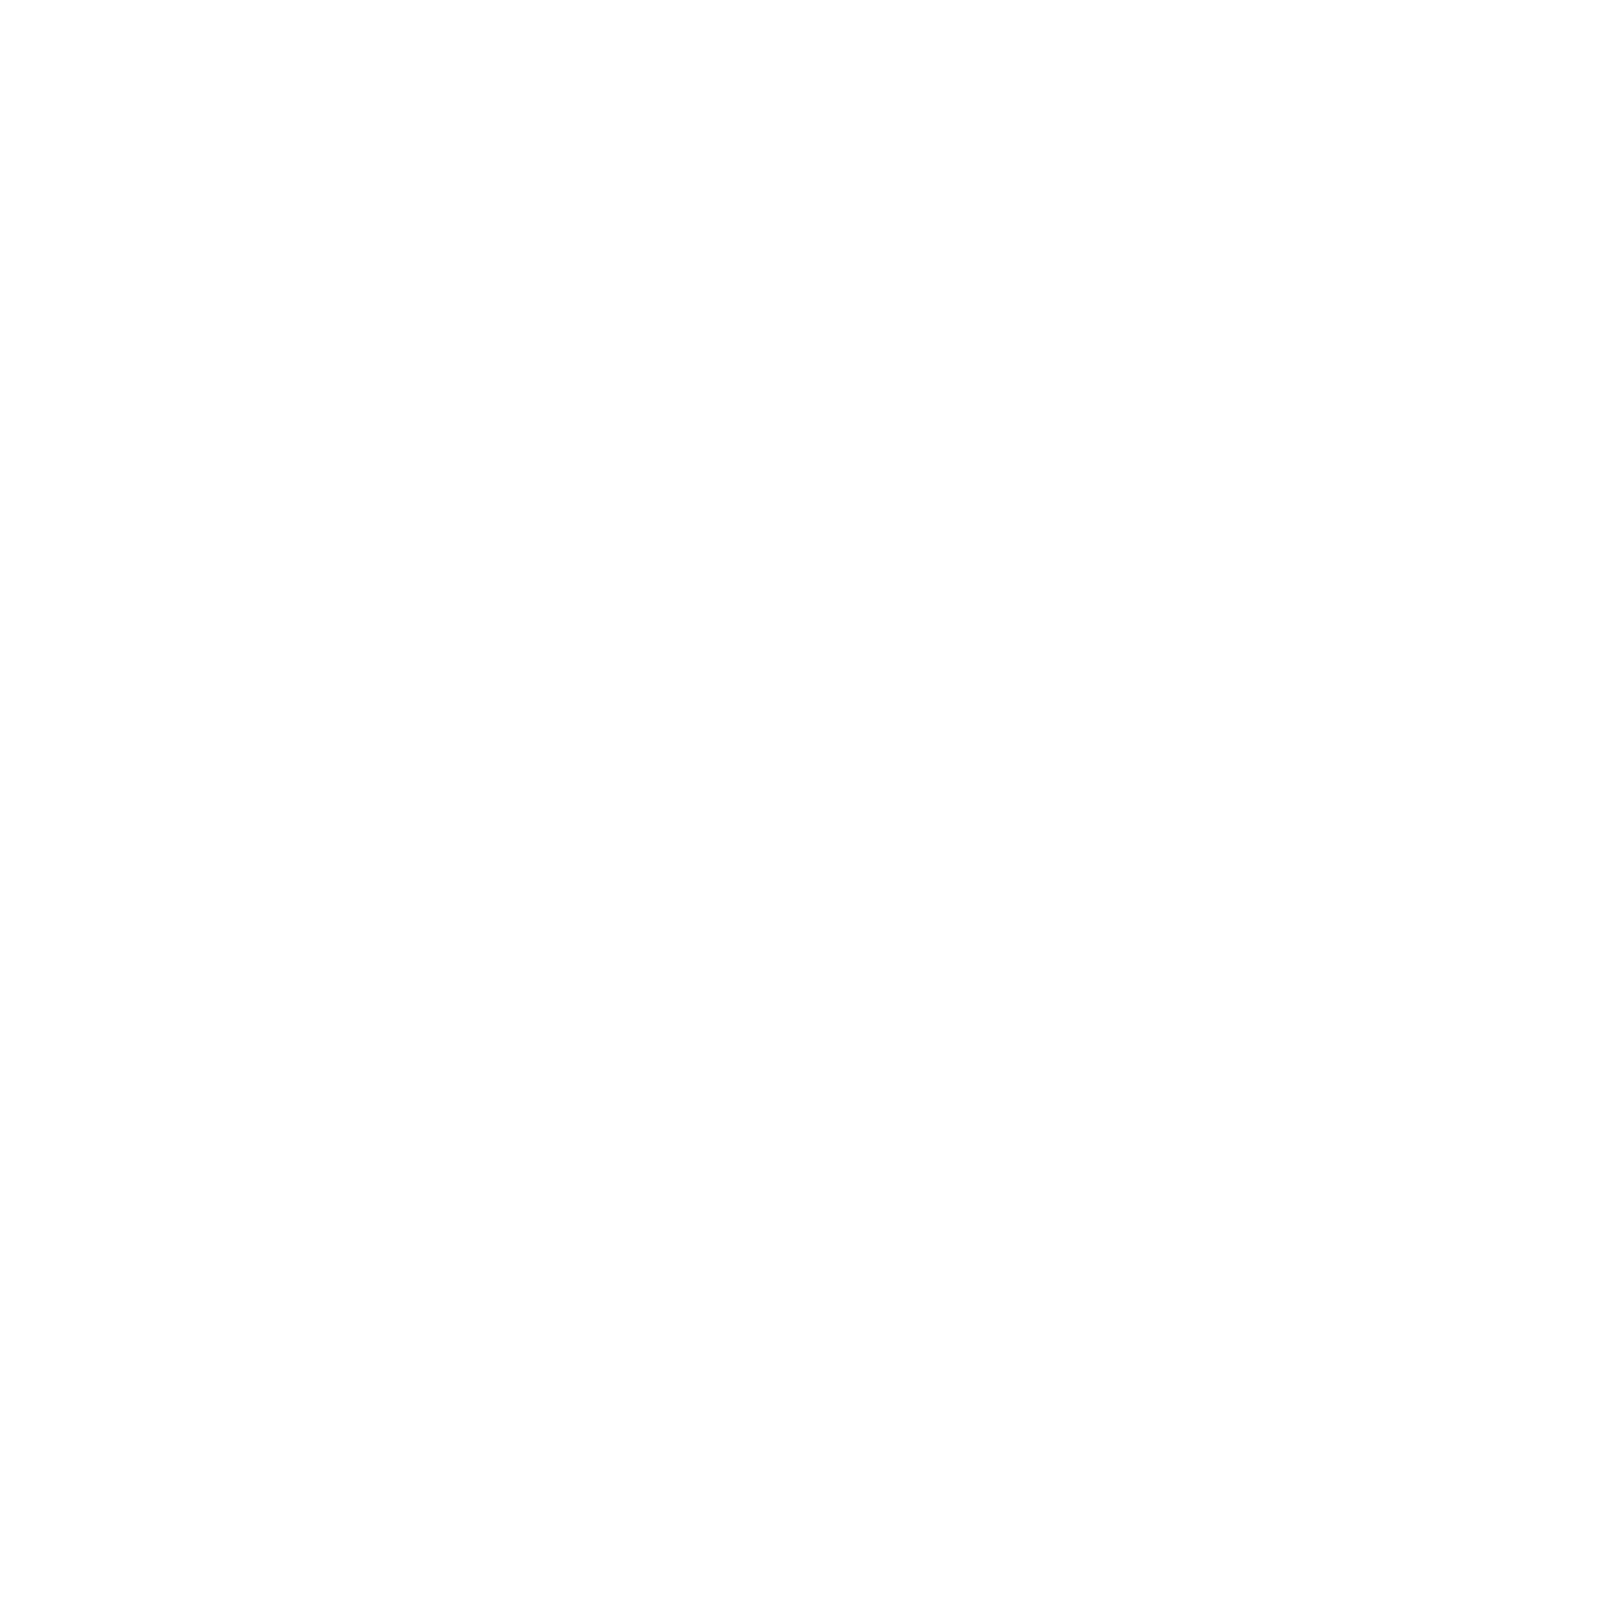

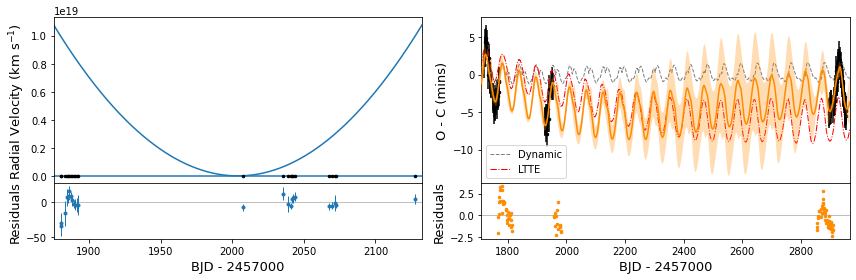

In [42]:
%matplotlib inline

from matplotlib import gridspec


# plot it
fig = plt.figure(figsize=(12, 4)) 

gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], hspace = 0) 
ax0 = plt.subplot(gs[0])

ax0.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model

pred_bkg = np.percentile(trace2["bkg_pred"], [16, 50, 84], axis=0)
ax0.plot(t, pred_bkg[1]*1, color="C0", label="model")
print (pred_bkg)


pred = np.percentile(trace2["rv_model_pred"], [16, 50, 84], axis=0)
ax0.plot(t, pred[1], color="C0", label="model")


art = ax0.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

#ax[0].legend(fontsize=10)
ax0.set_xlim(t.min(), t.max())
ax0.set_ylabel(r"Radial Velocity (km s$^{-1}$)", fontsize = 13)


ax1 = plt.subplot(gs[2])
ax1.errorbar(x,y - (trace2["rv_model"][1]), yerr=yerr*2, lw = 0, marker = 'o', color="C0", ms = 3, elinewidth = 1,label="model")

ax1.axhline(0, color = 'grey', zorder = -1, lw = 1, alpha = 0.5)
ax1.set_xlabel("BJD - 2457000", fontsize = 13)
ax1.set_ylabel("Residuals", fontsize = 13)
ax1.set_xlim(t.min(), t.max())

ax2 = plt.subplot(gs[1])

ax2.errorbar(x_etv, y_etv, yerr=yerr_etv, fmt=".k")
pred = np.percentile(trace2["etv_model_pred"], [16, 50, 84], axis=0)
ax2.plot(x_etv_array, pred[1], color="darkorange", zorder = 10) #, label="ETV model", 
art = ax2.fill_between(x_etv_array, pred[0], pred[2], color="darkorange", alpha=0.3, zorder = 10)
art.set_edgecolor("none")

pred = np.percentile(trace2["delta_dyn_pred"], [16, 50, 84], axis=0)
ax2.plot(x_etv_array, pred[1], color="grey", label="Dynamic", ls = '--', lw = 1)
#art = ax[1].fill_between(x_etv_array, pred[0], pred[2], color="grey", alpha=0.3)
#art.set_edgecolor("none")

pred = np.percentile(trace2["delta_ltte_pred"], [16, 50, 84], axis=0)
ax2.plot(x_etv_array, pred[1], color="red", label="LTTE", ls = '-.', lw = 1)


#ax[1].legend(fontsize=10)
ax2.set_xlim(x_etv_array.min(), x_etv_array.max())
ax2.legend()
ax2.set_ylabel("O - C (mins)", fontsize = 13)


ax3 = plt.subplot(gs[3])
ax3.plot(x_etv,y_etv - trace2["etv_model"][1], '.k', color="darkorange", label="model")
ax3.axhline(0, color = 'grey', zorder = -1, lw = 1, alpha = 0.5)
ax3.set_xlabel("BJD - 2457000", fontsize = 13)
ax3.set_ylabel("Residuals", fontsize = 13)
plt.tight_layout()

#plt.savefig('/Users/Nora/Documents/research/projects/fluffy/figs/470710327_ETV_rvs_2.png', dpi = 300)


<IPython.core.display.Javascript object>


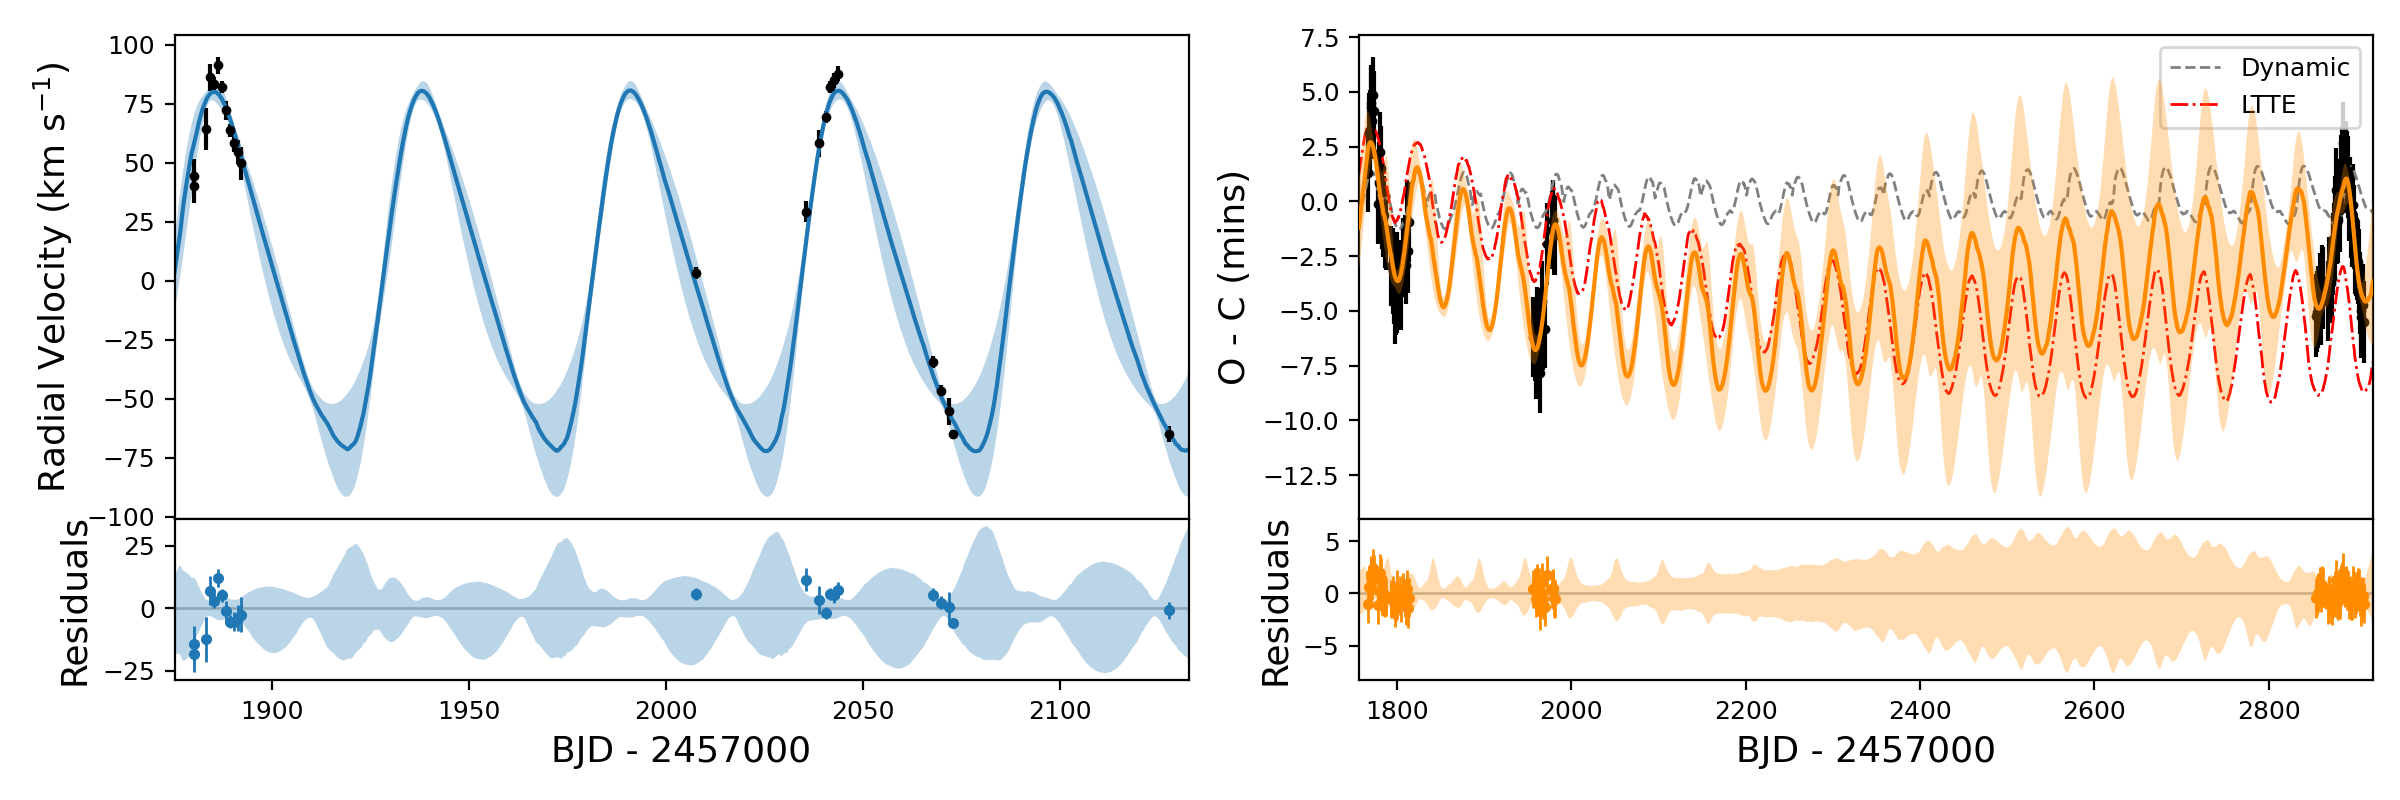

In [51]:
%matplotlib notebook

from matplotlib import gridspec


# plot it
fig = plt.figure(figsize=(12, 4)) 

gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], hspace = 0) 
ax0 = plt.subplot(gs[0])

ax0.errorbar(x, y, yerr=rv_error, fmt=".k")

# Compute the posterior predictions for the RV model

#pred_bkg = np.percentile(trace2["bkg_pred"], [16, 50, 84], axis=0)
#ax0.plot(t, pred_bkg[1]*1, color="C0", label="model")
#print (pred_bkg)

pred = np.percentile(trace2["rv_model_pred"], [16, 50, 84], axis=0)
pred_points = np.percentile(trace2["rv_model"], [16, 50, 84], axis=0)
pred_bkg = np.percentile(trace2["bkg_pred"], [16, 50, 84], axis=0)
pred_bkg_points = np.percentile(trace2["bkg"], [16, 50, 84], axis=0)

#ax0.plot(t, pred_bkg[1], color="grey", label="model")

bbkkgg = pred_bkg[1]*0
bbkkgg_points = pred_bkg_points[1]*0

ax0.plot(t, pred[1] + bbkkgg, color="C0", label="model")

art = ax0.fill_between(t, pred[0] + bbkkgg, pred[2] + bbkkgg, color="C0", alpha=0.3)
art.set_edgecolor("none")

#ax[0].legend(fontsize=10)
ax0.set_xlim(t.min(), t.max())
ax0.set_ylabel(r"Radial Velocity (km s$^{-1}$)", fontsize = 13)


ax1 = plt.subplot(gs[2])
ax1.errorbar(x,y - (pred_points[1] + bbkkgg_points), yerr=rv_error, lw = 0, marker = 'o', color="C0", ms = 3, elinewidth = 1,label="model")

ax1.axhline(0, color = 'grey', zorder = -1, lw = 1, alpha = 0.5)
ax1.set_xlabel("BJD - 2457000", fontsize = 13)
ax1.set_ylabel("Residuals", fontsize = 13)
ax1.set_xlim(t.min(), t.max())

art2 = ax1.fill_between(t, pred[0] - pred[1], pred[2] - pred[1], color="C0", alpha=0.3)
art2.set_edgecolor("none")




ax2 = plt.subplot(gs[1])


ax2.errorbar(x_etv, y_etv, yerr=yerr_etv, fmt=".k")
pred_etv = np.percentile(trace2["etv_model_pred"], [16, 50, 84], axis=0)
pred_etv_points = np.percentile(trace2["etv_model"], [16, 50, 84], axis=0)

ax2.plot(x_etv_array, pred_etv[1], color="darkorange", zorder = 10) #, label="ETV model", 
art = ax2.fill_between(x_etv_array, pred_etv[0], pred_etv[2], color="darkorange", alpha=0.3, zorder = 10)
art.set_edgecolor("none")


# -----

pred = np.percentile(trace2["delta_dyn_pred"], [16, 50, 84], axis=0)
ax2.plot(x_etv_array, pred[1], color="grey", label="Dynamic", ls = '--', lw = 1)
#art = ax[1].fill_between(x_etv_array, pred[0], pred[2], color="grey", alpha=0.3)
#art.set_edgecolor("none")

pred = np.percentile(trace2["delta_ltte_pred"], [16, 50, 84], axis=0)

ax2.plot(x_etv_array, pred[1], color="red", label="LTTE", ls = '-.', lw = 1)


#ax[1].legend(fontsize=10)
ax2.set_xlim(x_etv_array.min(), x_etv_array.max())
ax2.legend()
ax2.set_ylabel("O - C (mins)", fontsize = 13)


ax3 = plt.subplot(gs[3])
ax3.errorbar(x_etv, y_etv - pred_etv_points[1], yerr=yerr_etv, lw = 0, marker = 'o', color="darkorange", ms = 3, elinewidth = 1,label="model")

#ax3.plot(x_etv,y_etv - trace2["etv_model"][1], '.k', color="darkorange", label="model")
ax3.axhline(0, color = 'grey', zorder = -1, lw = 1, alpha = 0.5)
ax3.set_xlabel("BJD - 2457000", fontsize = 13)
ax3.set_ylabel("Residuals", fontsize = 13)

art4 = ax3.fill_between(x_etv_array, pred_etv[0] - pred_etv[1], pred_etv[2] - pred_etv[1], color="darkorange", alpha=0.3)
art4.set_edgecolor("none")

ax2.set_xlim(x_etv_array.min(), x_etv_array.max())
ax3.set_xlim(x_etv_array.min(), x_etv_array.max())

plt.tight_layout()

#plt.savefig('/Users/Nora/Documents/research/projects/fluffy/figs/470710327_ETV_rvs_2.png', dpi = 300)


<IPython.core.display.Javascript object>


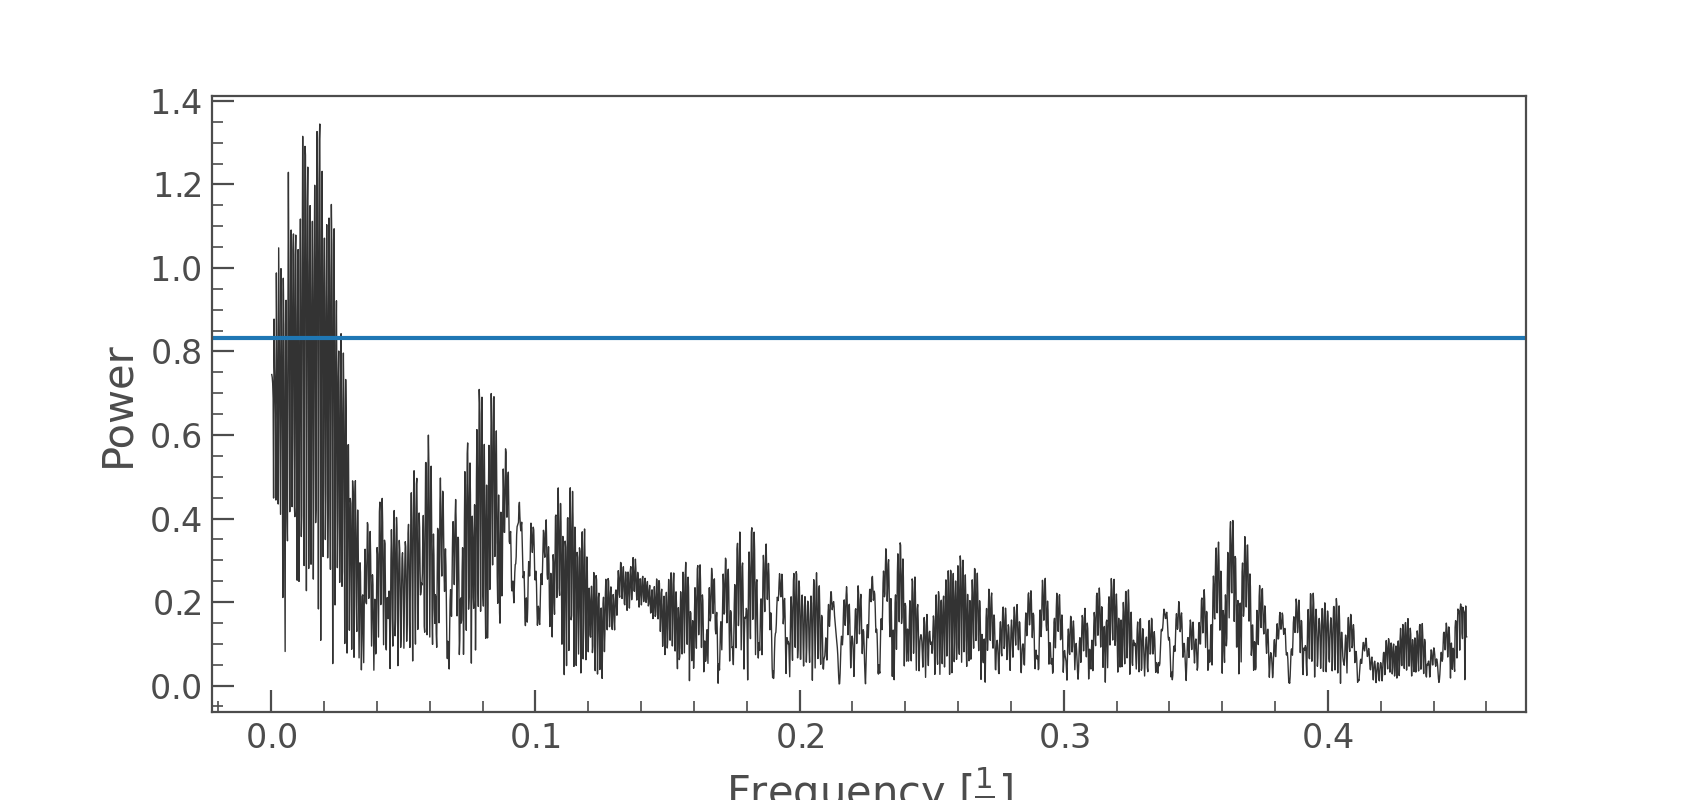

In [44]:
import lightkurve as lk

lc = lk.lightcurve.LightCurve(time = x_etv, flux = y_etv - trace2["etv_model"][1])

ls = lc.to_periodogram()

ax = ls.plot();
#k = ls.smooth(method='boxkernel', filter_width=25.)
#k.plot(scale = 'log', ax = ax, color = 'red', lw = 2)

ax.axhline(4.*np.mean(ls.power))
plt.show()

#x,y - trace2["rv_model"][1]

#lc = lk.lightcurve.LightCurve(time = x, flux = y - trace2["rv_model"][1])

#ls = lc.to_periodogram()

#ax = ls.plot();
##k = ls.smooth(method='boxkernel', filter_width=25.)
##k.plot(scale = 'log', ax = ax, color = 'red', lw = 2)
#
#ax.axhline(4.*np.mean(ls.power))
#
#plt.show()

In [45]:
import collections

def aic(y, y_pred, p):
    
    n = len(y)
    
    # Calculation
    resid = np.subtract(y_pred, y)
    rss = np.sum(np.power(resid, 2))
    aic_score = n*np.log(rss/n) + 2*p
    
    return aic_score

def bic(y, y_pred, p):
    
    n = len(y)
    
    # Score
    
    residual = np.subtract(y_pred, y)
    SSE = np.sum(np.power(residual, 2))
    BIC = n*np.log(SSE/n) + p*np.log(n)
    
    return BIC

In [46]:
AIC_etv = aic(y_etv, trace["etv_model"][1], 16)
BIC_etv = bic(y_etv, trace["etv_model"][1], 16)

AIC_rv = aic(y, trace["rv_model"][1], 16)
BIC_rv = bic(y, trace["rv_model"][1], 16)

In [47]:
print("AIC_rv                       : {}".format(AIC_rv))
print("BIC_rv                       : {}".format(BIC_rv))
print ("stdv rv residuals            : {}".format(np.std(y - trace["rv_model"][1])))
print ()   
print("AIC_etv                      : {}".format(AIC_etv))
print("BIC_etv                      : {}".format(BIC_etv))
print ("stdv etv residuals           : {} ".format(np.std(y_etv - trace["etv_model"][1])))

print ()
print("AIC_total                    : {}".format(AIC_rv + AIC_etv))
print("BIC_total                    : {}".format(BIC_rv + BIC_etv))


AIC_rv                       : 144.59448365349778
BIC_rv                       : 163.4433449390649
stdv rv residuals            : 10.292340363620509

AIC_etv                      : 76.87256115244963
BIC_etv                      : 117.22117838523428
stdv etv residuals           : 1.2750959200885525 

AIC_total                    : 221.4670448059474
BIC_total                    : 280.6645233242992


In [48]:
# find the mass of the stars

In [49]:
def calculate_asini_from_RV(ecc,K,Porb):
    # Calculates asini according to RV variations
    # K in km/s
    # Porb in days
    # Returns asini in Rsun
    # eq --> asini = (1.9758e-2) * sqrt(1 - ecc^2) * K * Porb
    return (1.9758e-2) * np.sqrt(1-ecc**2) * K * Porb



In [50]:
asini_rv = calculate_asini_from_RV(e_trip,np.exp(trace[0]['logK']),P_trip)
asini_etv = trace[0]['asini']

NameError: name 'e_trip' is not defined

In [ ]:
def etv_dyn(t, P3, tp, ecc3, i_mutual, mass_ratio, g2):
    
    true_anom3 = radvel.orbit.true_anomaly(t, tp, P3, ecc3)
    
    #M = tt.zeros_like(tt.constant(t)) + 2.0 * np.pi * (tt.constant(t)) / P3
    #true_anom3 = get_true_anomaly(M, ecc3 + tt.zeros_like(M))
    
    
    MM = ((3. * ecc3 * np.sin(true_anom3)) - ( (3./4.) * (ecc3**2) * (np.sin(2*true_anom3))) + 
          ((1/3.) * (ecc3**3) * (np.sin(3*true_anom3))))
    SS = np.sin((2* true_anom3) + (2*g2)) + (ecc3 * (np.sin(true_anom3 + (2*g2)) + 
            (1/3. * np.sin((3.*true_anom3) + (2 * g2)))))
    

    delta_dyn = (((3. / (4 * np.pi)) * (mass_ratio) * (((P12*u.day)**2)/(P3*u.day)) * (1. - (ecc3**2))**(-3./2)) *
                ((((2./3) - (np.sin(i_mutual)**2)) * MM) + (0.5*(np.sin(i_mutual)**2) * SS))).to('minute').value
    
    
    return delta_dyn


def etv_ltte(t, t012, c0, c1, c2, P12, P3, tp, ecc3, asini):
    
    E = abs(np.round((t - t012) / P12, 1))

    #M = tt.zeros_like(tt.constant(t)) + 2.0 * np.pi * (tt.constant(t)) / P3
    #true_anom3 = get_true_anomaly(M, ecc3 + tt.zeros_like(M))

    true_anom3 = radvel.orbit.true_anomaly(t, tp, P3, ecc3)
    
    # convert from Rsun to m
    asini_m  = asini * 696000000 
    c = 299792458 # m/s
    
    delta_LTTE = - (((asini*u.Rsun)/co.c) * (((1 - (ecc3**2.)) * np.sin(true_anom3 + omega3)) / (1 + ecc3*np.cos(true_anom3)))).to('minute').value # convert from seconds to minutes
    
    return c0 + (c1*E) + (c2*E**2) + (delta_LTTE)
    
    
def etv_model(t, t012, c0, c1, c2, P12, P3, tp, ecc3, omega3, i_mutual, mass_ratio, asini, g2):
    
    E = abs(np.round((t - t012) / P12, 1))
    
    #M = tt.zeros_like(tt.constant(t)) + 2.0 * np.pi * (tt.constant(t)) / P3
    #true_anom3 = get_true_anomaly(M, ecc3 + tt.zeros_like(M))

    delta_dyn = etv_dyn(t, P3, tp, ecc3, i_mutual, mass_ratio, g2)
    delta_LTTE = etv_ltte(t, t012, c0, c1, c2, P12, P3, tp, ecc3, asini)
    
    return delta_dyn,delta_LTTE



In [ ]:
tp = 1879.326
#c0 = np.median(trace2['c0'])
#c1 = np.median(trace2['c1'])
#c2 = np.median(trace2['c2'])
P12 = 1.1047
t012 =  1766.28
P3 = 52.005
ecc3 = 0.306
omega3  = -1.279
i_mutual  = 2.685
mass_ratio  = 0.584
asini  = 88.888
g2  = 2.876



In [ ]:
ltte, dyn = etv_model(x_etv_array, t012, 0, 0, 0, P12, P3, tp-7, ecc3, omega3, i_mutual, mass_ratio, asini, g2)
ltte2, dyn2 = etv_model(x_etv_array, t012, 0, 0.007, 0, P12, P3, tp-5, ecc3, omega3, i_mutual, mass_ratio, asini, g2)


fig = plt.figure(figsize=(6, 4)) 

plt.errorbar(x_etv, y_etv, yerr=yerr_etv, fmt=".k", alpha = 0.3)

#plt.plot(x_etv_array, ltte, color="darkorange", alpha =0.7, ls = '--')
#plt.plot(x_etv_array, dyn, color="blue", alpha=0.7, ls = '--')
#plt.plot(x_etv_array, lt bte + dyn, color="black")
plt.plot(x_etv_array, ltte2 + dyn2, color="red")

plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
#_ = ax[1].set_title("posterior constraints")


In [ ]:
def etv_fit_rap(t, t012, c0, c1, c2, P12, P3, tp, e3, omega3, i_mutual, mutual_anom, mass_ratio, sinitrip):
    
    #P12 = (P12 * u.day).to("second").value
    #P3 = (P3 * u.day).to("second").value
    
    E = abs(np.round((t - t012) / P12, 1))
    
    mean_anom3 = (2* np.pi * (t - tp)) / P3 
    true_anom3 = radvel.orbit.true_anomaly(t, tp, P3, e3)
    ecc_anom3 = radvel.kepler.kepler(mean_anom3, np.ones_like(mean_anom3)*e3)
    
    # from Rappaport 2013
    
    
    phys_amplitude = ((3. / (np.pi * 8.)) * (mass_ratio) * ((P12*u.day)**2/(P3*u.day)) * ((1.-(e3**2)) ** (-1.5))).to('minute').value
    
    phys1 = (((2. * I) - 2./3.) * (true_anom3 + (e3*np.sin(true_anom3)) - mean_anom3))
    
    phys2 = ((1 - I) * (np.sin((2*true_anom3) - (2*mutual_anom))  
                                          + (e3*np.sin(true_anom3 - (2*mutual_anom)))
                                          + ((e3/3.) * np.sin((3*true_anom3) - (2*mutual_anom)))))
    
    
    return phys_amplitude * (phys1 + phys2)



In [ ]:
etv_fit_rap(t, t012, c0, c1, c2, P12, P3, tp, e3, omega3, i_mutual, mutual_anom, mass_ratio, sinitrip)

In [ ]:
k = 1.459839

round(k,3)

In [ ]:
time_s = +(15  * 1800) \
+(15*1800) \
+(9*1200) \
+(15 * 1800) \
+(3 * 1800 * 3) \
+(20 * 1200) \
+(17*900) \
+(10 * 1800) \
+(15 * 1800 ) \
+(4 * 1800) \
+(5 * 1800 * 3) \
+(2 * 1800 * 3) \
+(3 * 1800 * 3) \

In [ ]:
time_s / 60 /60


In [ ]:
3 * 1800 * 3 / 60 /60

In [ ]:
7.5 + 7.5 + 3 + 7.5 +  4.5 


In [ ]:
6.7 + 4.5 + 5 + 7.5 + 7.5 + 3 + 2

In [ ]:

logs    =  [1.96236        , 1.87289    , 2.02353]
omega    =  [-1.12299      , -1.18592   , -1.00782]
ecc3    =  [0.29972        , 0.2906     , 0.31239]
t0    =  [1880.39417       , 1880.12743 , 1881.10743]
logK    =  [4.2788         , 4.26011    , 4.30123]
P    =  [52.04412          , 52.02733   , 52.06075]
c0    =  [-0.51181         , -0.59912   , -0.39882]
c1    =  [-0.00219         , -0.01005   , 0.00075]
c2    =  [7e-05            , 5e-05      , 0.0001]
i_mutual    =  [0.29361    , 0.27002    , 0.36709]
g2    =  [-0.01662         , -0.73501   , -0.22657]
asini_ab    =  [91.21883   , 80.56783   , 93.88978]
mass_ratio    =  [0.56264  , 0.54896    , 0.59422]
asini_c    =  [70.92252    , 68.89313   , 71.89926]
q_    =  [1.28645          , 1.11006    , 1.33537]

In [ ]:
print (g2[2] - g2[0])